In [70]:
from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import *
from utils.concept_reps import *
import torch
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
plt.style.use('default')

# Analysis of length cost runs with shared context
This notebook contains quantitative and qualitative analyses.

In [71]:
datasets = ['(3,4)', '(3,8)', '(3,16)', '(4,4)', '(4,8)', '(5,4)']
n_values = [4, 8, 16, 4, 8, 4]
n_attributes = [3, 3, 3, 4, 4, 5]
vocab_sizes = [5, 9, 17, 5, 9, 5]
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_0' for d in datasets]

In [72]:
context_unaware = False # whether original or context_unaware simulations are evaluated
length_cost = True # whether length_cost was applied
early_stopping = True
sampled_context = False # actually true, but this would navigate to a different folder
hierarchical = False
shared_context = True
test_interactions = False # whether scores should be calculated on test interactions
test_mode = 'test'
setting = ""
if length_cost:
    setting = setting + "length_cost"
if context_unaware:
    setting = setting + "/context_unaware"
else:
    setting = setting + "/context_aware"
if hierarchical:
    setting = setting + "/hierarchical"
if shared_context:
    setting = setting + "/shared_context"

In [73]:
# get n_epochs if early stopping
if early_stopping:
    
    n_epochs_all_data = []
    for d in range(len(datasets)):
        
        epochs = []
        
        for run in range(n_runs):
    
            path_to_run = paths[d] + '/' + setting +'/' + str(run) + '/' 
            with open(os.path.join(path_to_run, 'loss_and_metrics.pkl'), 'rb') as input_file:
                data = pickle.load(input_file)
                final_epoch = max(data['loss_train'].keys())
                epochs.append(final_epoch)
                
        n_epochs_all_data.append(epochs)
        
else:
    n_epochs_all_data = []
    for d in range(len(datasets)):
        epochs = []
        
        for run in range(n_runs):
            epochs.append(n_epochs)
                
        n_epochs_all_data.append(epochs)
        

# Quantitative analysis
## Train interactions
### Training
Ease of developing a language in the scenario: How quickly was a language established, i.e. number of epochs? What was the learning speed?

In [74]:
# gather epochs
epochs_training = {}
for i, d in enumerate(datasets):
    gather_epochs = []
    for run in range(n_runs):
        gather_epochs.append(n_epochs_all_data[i][run])
    epochs_training[d] = (round(np.mean(gather_epochs), 3), round(np.std(gather_epochs), 3))
if context_unaware:
    df_unaware = pd.DataFrame(epochs_training).transpose().rename(columns={0: 'mean', 1: 'sd'})
    df_unaware['context-unaware'] = df_unaware.apply(lambda row: f'{row["mean"]:.2f} ± {row["sd"]:.2f}', axis=1)
else:
    df_aware = pd.DataFrame(epochs_training).transpose().rename(columns={0: 'mean', 1: 'sd'})
    df_aware['context-aware'] = df_aware.apply(lambda row: f'{row["mean"]:.2f} ± {row["sd"]:.2f}', axis=1)
try:
    df_acc = pd.concat([df_unaware['context-unaware'], df_aware['context-aware']], axis=1)
    latex_table = df_acc.to_latex()
    print(latex_table)
except KeyError or NameError:
    print("Run this section with context_unaware = True and context_unaware = False.")

\begin{tabular}{lll}
\toprule
{} & context-unaware &  context-aware \\
\midrule
(3,4)  &    61.20 ± 5.49 &   42.60 ± 5.00 \\
(3,8)  &    64.80 ± 6.18 &  55.60 ± 10.59 \\
(3,16) &    64.20 ± 9.93 &  73.00 ± 48.73 \\
(4,4)  &   55.20 ± 11.34 &   45.80 ± 8.70 \\
(4,8)  &   44.00 ± 13.21 &  62.40 ± 37.64 \\
(5,4)  &    30.40 ± 6.83 &   37.80 ± 9.93 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_85355/2162866421.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_acc.to_latex()


### Training trajectories
TODO

### Accuracies

In [75]:
test_interactions = False

In [76]:
all_accuracies = load_accuracies(paths, n_runs=n_runs, n_epochs=300, val_steps=1, zero_shot=False, context_unaware=context_unaware, length_cost=length_cost, early_stopping=early_stopping, sampled_context=sampled_context, hierarchical=hierarchical, shared_context=shared_context)

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/load_results.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


#### Final accuracies 
Final accuracies heatmap plot + get accuracy means and sds for table representation.

In [11]:
if not context_unaware:
    accuracies = [all_accuracies['train_acc'], all_accuracies['val_acc']]
    test_accuracies = all_accuracies['test_acc']
else:
    accuracies = [all_accuracies['cu_train_acc'], all_accuracies['cu_val_acc']]
    test_accuracies = all_accuracies['cu_test_acc']

In [12]:
# training
final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(n_runs):
        if not context_unaware:
            gather_accuracies.append(all_accuracies['train_acc'][i][run][-1])
        else:
            gather_accuracies.append(all_accuracies['cu_train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
df_train = pd.DataFrame(final_accuracies_train).transpose().rename(columns={0: 'mean', 1: 'sd'})
df_train['train'] = df_train.apply(lambda row: f'{row["mean"]:.2f} ± {row["sd"]:.2f}', axis=1)

In [13]:
# validation
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(n_runs):
        if not context_unaware:
            gather_accuracies.append(all_accuracies['val_acc'][i][run][-1])
        else:
            gather_accuracies.append((all_accuracies['cu_val_acc'][i][run][-1]))
    print(gather_accuracies)
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
df_val = pd.DataFrame(final_accuracies_val).transpose().rename(columns={0: 'mean', 1: 'sd'})
df_val['validation'] = df_val.apply(lambda row: f'{row["mean"]:.2f} ± {row["sd"]:.2f}', axis=1)

[0.9606639742851257, 0.9837369918823242, 0.9517577886581421, 0.9677865505218506, 0.9503775238990784]
[0.9866071343421936, 0.9824219346046448, 0.9885581731796265, 0.9795843958854675, 0.9566149115562439]
[0.9911856651306152, 0.9888027906417847, 0.8835982084274292, 0.9950907826423645, 0.9931459426879883]
[0.968795120716095, 0.9933793544769287, 0.9762795567512512, 0.9770632982254028, 0.99065762758255]
[0.9926860332489014, 0.9934724569320679, 0.9918938875198364, 0.9709591865539551, 0.9440508484840393]
[0.9858182668685913, 0.9910926818847656, 0.9828721284866333, 0.9902623891830444, 0.965690016746521]


In [14]:
test_accuracies

array([[0.93696004, 0.94049996, 0.90125251, 0.9530375 , 0.91722739],
       [0.97374785, 0.98027402, 0.98459756, 0.95851249, 0.95195848],
       [0.99123049, 0.98551905, 0.85930705, 0.99304169, 0.99171382],
       [0.96941757, 0.98862743, 0.97119999, 0.97852004, 0.9898001 ],
       [0.99208438, 0.99254882, 0.99292564, 0.97127932, 0.94473183],
       [0.98463196, 0.98991001, 0.98483253, 0.98980904, 0.96436977]])

In [16]:
def calc_mean_std(row):
    mean = np.mean(row)
    std = np.std(row)
    return f'{mean:.2f} ± {std:.2f}'

results = np.apply_along_axis(calc_mean_std, 1, test_accuracies)
df_test = pd.DataFrame(results, columns=['test'])
df_test.index = datasets

In [17]:
df_acc = pd.concat([df_train['train'], df_val['validation'], df_test], axis=1)
latex_table = df_acc.to_latex()
print(latex_table)

\begin{tabular}{llll}
\toprule
{} &        train &   validation &         test \\
\midrule
(3,4)  &  0.99 ± 0.01 &  0.96 ± 0.01 &  0.93 ± 0.02 \\
(3,8)  &  0.99 ± 0.01 &  0.98 ± 0.01 &  0.97 ± 0.01 \\
(3,16) &  0.98 ± 0.02 &  0.97 ± 0.04 &  0.96 ± 0.05 \\
(4,4)  &  0.99 ± 0.00 &  0.98 ± 0.01 &  0.98 ± 0.01 \\
(4,8)  &  0.98 ± 0.02 &  0.98 ± 0.02 &  0.98 ± 0.02 \\
(5,4)  &  0.99 ± 0.01 &  0.98 ± 0.01 &  0.98 ± 0.01 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_85355/4150073812.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_acc.to_latex()


### Message length
#### Final message length

In [18]:
# training
final_ml_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(n_runs):
        if not context_unaware:
            gather_accuracies.append(all_accuracies['train_message_lengths'][i][run][-1])
        else:
            gather_accuracies.append(all_accuracies['cu_train_message_lengths'][i][run][-1])
    final_ml_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_ml_train

{'(3,4)': (4.523, 0.4),
 '(3,8)': (4.039, 0.228),
 '(3,16)': (4.281, 1.159),
 '(4,4)': (4.367, 0.38),
 '(4,8)': (4.842, 0.767),
 '(5,4)': (4.972, 0.321)}

#### Message length per dataset

In [19]:
ml_dict = {'dataset': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        if not test_interactions:
            ml = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length.pkl', 'rb'))
        else:
            ml = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_' + test_mode + '.pkl', 'rb'))
            
        ml_dict['run'].append(run)
        ml_dict['dataset'].append(dataset)
        try: 
            ml_dict['message length'].append(np.mean(ml.numpy()))
        except: 
            ml_dict['message length'].append(np.NaN)
df_ml = pd.DataFrame(ml_dict)

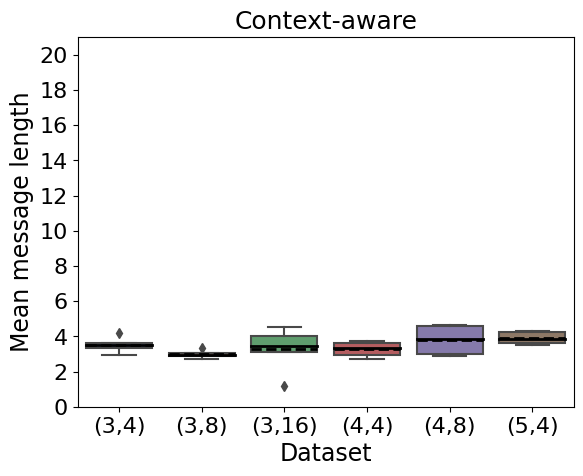

In [20]:
# Create a boxplot for each dataset
sns.boxplot(x='dataset', y='message length', data=df_ml, whis=1.5,
            palette='deep', showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
#g.set_titles(col_template="{col_name}", fontsize=50)
#g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
plt.xlabel(xlabel='Dataset', fontsize=17)
plt.ylabel(ylabel='Mean message length', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=16)
plt.ylim(0, 21)
#legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
#plt.setp(legend.get_title(),fontsize='x-large')
if context_unaware:
    plt.title('Context-unaware', fontsize=18)
else:
    plt.title('Context-aware', fontsize=18)
plt.show()

#### Message lengths per concept hierarchy level

In [21]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):

        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        if not test_interactions:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        else:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical_' + test_mode + '.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

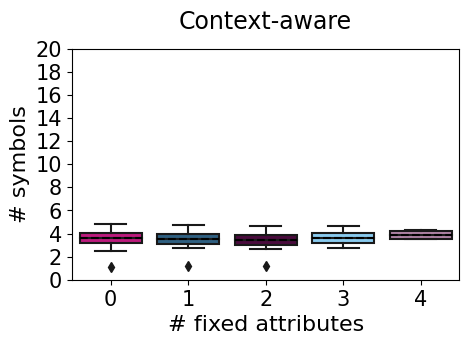

In [22]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]), showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=1.5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, ticks=[0,2,4,6,8,10,12,14,16,18,20])
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
if context_unaware:
    plt.title('Context-unaware', fontsize=17, y=1.05)
else:
    plt.title('Context-aware', fontsize=17, y=1.05)
plt.show()

In [23]:
df = pd.DataFrame(ml_dict)
agg = df.groupby('level').agg({'message length': ['mean', 'min', 'max']})
agg

message length              
                mean    min    max
level                             
0           3.605100  1.128  4.816
1           3.505133  1.161  4.729
2           3.454633  1.185  4.681
3           3.639933  2.723  4.658
4           3.891000  3.509  4.316

#### Message lengths in fine contexts

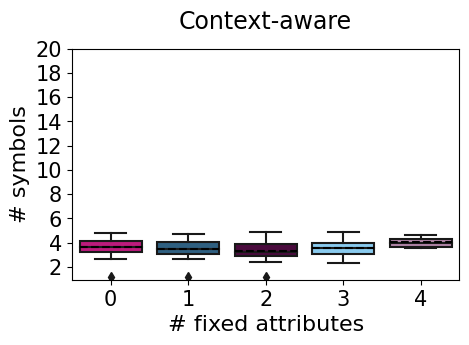

In [24]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):

        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        if not test_interactions:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_over_context.pkl', 'rb'))
        else:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_over_context_' + test_mode + '.pkl', 'rb'))
            
        for level in range(n_runs):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical['ml_fine_context'][level])
            except: 
                ml_dict['message length'].append(np.NaN)
                
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]), showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=1.5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, ticks=[2,4,6,8,10,12,14,16,18, 20])
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
if context_unaware:
    plt.title('Context-unaware', fontsize=17, y=1.05)
else:
    plt.title('Context-aware', fontsize=17, y=1.05)
plt.show()

### Lexicon sizes

In [25]:
# go through all datasets
for i, d in enumerate(datasets):
    print(d)
    n_epochs = n_epochs_all_data[i]
    for run in range(5):
        path_to_run = paths[i] + '/' + str(setting) +'/' + str(run) + '/'
        path_to_interaction_train = (path_to_run + 'interactions/train' + '/epoch_' + str(n_epochs[run]) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation' + '/epoch_' + str(n_epochs[run]) + '/interaction_gpu0')
        interaction_train = torch.load(path_to_interaction_train)
        interaction_val = torch.load(path_to_interaction_val)
        
        concepts_train = objects_to_concepts(interaction_train.sender_input, n_values[i])
        concepts_val = objects_to_concepts(interaction_val.sender_input, n_values[i])
        context_train = objects_to_context(interaction_train.sender_input, n_values[i])
        context_val = objects_to_context(interaction_val.sender_input, n_values[i])
        print("concepts train", len(concepts_train), "concepts val", len(concepts_val))
                
        accuracies_train = interaction_train.aux['acc']
        accuracies_val = interaction_val.aux['acc']
        
        # specific and generic concepts train dataset
        specific_concepts_train, generic_concepts_train, specific_indices, generic_indices, coarse_context_indices, fine_context_indices = [], [], [], [], [], []
        for idx, (objects, fixed) in enumerate(concepts_train):
            if sum(fixed) == n_attributes[i]:
                specific_concepts_train.append((objects, fixed))
                specific_indices.append(idx)
                if context_train[idx] == 0:
                    coarse_context_indices.append(idx)
                if context_train[idx] == (n_attributes[i] - 1):
                    fine_context_indices.append(idx)
            if sum(fixed) == 1:
                generic_concepts_train.append((objects, fixed))
                generic_indices.append(idx)
        
        messages_train = retrieve_messages(interaction_train)
        messages_val = retrieve_messages(interaction_val)
        
        # remove all symbols after EOS
        messages_train = [remove_symbs_after_eos(message) for message in messages_train]
        messages_val = [remove_symbs_after_eos(message) for message in messages_val]
        print("messages train", len(messages_train), "messages val", len(messages_val))
        
        # messages used for specific and generic concepts
        specific_messages_train = [messages_train[idx] for idx in specific_indices]
        generic_messages_train = [messages_train[idx] for idx in generic_indices]
        
        # accuracies for specific and generic concepts
        accs_train_specific = [accuracies_train[idx] for idx in specific_indices]
        accs_train_specific_fine = [accuracies_train[idx] for idx in fine_context_indices]
        accs_train_specific_coarse = [accuracies_train[idx] for idx in coarse_context_indices]
        accs_train_generic = [accuracies_train[idx] for idx in generic_indices]
    
        symbol_counts_train = count_symbols(messages_train)
        symbol_counts_val = count_symbols(messages_val)
        symbol_counts = [symbol_counts_train, symbol_counts_val]
        pickle.dump(symbol_counts, open(path_to_run + 'symbol_counts_' + 'trainval' + '.pkl', 'wb'))
        
        # consider only unique messages
        messages_train_unique = get_unique_message_set(messages_train)
        messages_val_unique = get_unique_message_set(messages_val)
        specific_messages_train_unique = get_unique_message_set(specific_messages_train)
        generic_messages_train_unique = get_unique_message_set(generic_messages_train)
        messages_comb = [len(messages_train_unique), len(messages_val_unique), len(specific_messages_train_unique), len(generic_messages_train_unique)]
        
        # concepts
        concepts_train_unique = get_unique_concept_set(concepts_train)
        concepts_val_unique = get_unique_concept_set(concepts_val)
        specific_concepts_train_unique = get_unique_concept_set(specific_concepts_train)
        generic_concepts_train_unique = get_unique_concept_set(generic_concepts_train)
        num_of_concepts = [len(concepts_train_unique), len(concepts_val_unique), len(specific_concepts_train_unique), len(generic_concepts_train_unique)]
        pickle.dump(num_of_concepts, open(path_to_run + 'num_of_concepts_' + 'train' + '.pkl', 'wb'))
        
        accuracies = [float(torch.mean(torch.stack(accs_train_specific))), float(torch.mean(torch.stack(accs_train_specific_fine))), float(torch.mean(torch.stack(accs_train_specific_coarse))), float(torch.mean(torch.stack(accs_train_generic)))]
        pickle.dump(accuracies, open(path_to_run + 'accuracies_' + 'train' + '.pkl', 'wb'))

(3,4)
concepts train 742 concepts val 240
messages train 742 messages val 240
concepts train 742 concepts val 240
messages train 742 messages val 240
concepts train 742 concepts val 240
messages train 742 messages val 240
concepts train 742 concepts val 240
messages train 742 messages val 240
concepts train 742 concepts val 240
messages train 742 messages val 240
(3,8)
concepts train 4364 concepts val 1456
messages train 4364 messages val 1456
concepts train 4364 concepts val 1456
messages train 4364 messages val 1456
concepts train 4364 concepts val 1456
messages train 4364 messages val 1456
concepts train 4364 concepts val 1456
messages train 4364 messages val 1456
concepts train 4364 concepts val 1456
messages train 4364 messages val 1456
(3,16)
concepts train 29467 concepts val 9808
messages train 29467 messages val 9808
concepts train 29467 concepts val 9808
messages train 29467 messages val 9808
concepts train 29467 concepts val 9808
messages train 29467 messages val 9808
concept

In [26]:
acc_dict = {'train specific': [], 'train generic': [], 'train fine': [], 'train coarse': []}
for i, d in enumerate(datasets):
    accs_train_specific, accs_train_specific_fine, accs_train_specific_coarse, accs_train_generic = [], [], [], []
    for run in range(5):
        path_to_run = paths[i] + '/' + str(setting) +'/' + str(run) + '/'
        acc_means = pickle.load(open(path_to_run + 'accuracies_' + 'train' + '.pkl', 'rb'))
        for j, acc in enumerate(acc_means):
            if j == 0:
                accs_train_specific.append(acc)
            elif j == 1:
                accs_train_specific_fine.append(acc)
            elif j == 2:
                accs_train_specific_coarse.append(acc)
            elif j == 3:
                accs_train_generic.append(acc)
    acc_dict['train specific'].append(accs_train_specific)
    acc_dict['train fine'].append(accs_train_specific_fine)
    acc_dict['train coarse'].append(accs_train_specific_coarse)
    acc_dict['train generic'].append(accs_train_generic)

In [27]:
accuracies = [acc_dict['train specific'], acc_dict['train generic'], acc_dict['train fine'], acc_dict['train coarse']]

# Convert the list to a NumPy array
acc_array = np.array(accuracies)

# Compute means and standard deviations over the five runs
means = np.mean(acc_array, axis=-1)
std_devs = np.std(acc_array, axis=-1)

# Row names and column names
row_names = ["D(3,4)", "D(3,8)", "D(3,16)", "D(4,4)", "D(4,8)", "D(5,4)"]
col_names = ["train specific", "train generic", "train fine", "train coarse"]

# Prepare the data for the DataFrames
data = []

# iterate over datasets
for i in range(means.shape[1]):
    row = []
    # iterate over conditions
    for j in range(means.shape[0]):
        formatted_value = f"{means[j, i]:.2f} $\\pm$ {std_devs[j, i]:.2f}"
        row.append(formatted_value)
    data.append(row)

# Create DataFrames
df = pd.DataFrame(data, index=row_names, columns=col_names)

# Convert DataFrames to LaTeX tables
latex_table = df.to_latex(index=True, escape=False)

print(latex_table)

\begin{tabular}{lllll}
\toprule
{} &   train specific &    train generic &       train fine &     train coarse \\
\midrule
D(3,4)  &  0.99 $\pm$ 0.01 &  0.99 $\pm$ 0.01 &  0.99 $\pm$ 0.01 &  0.99 $\pm$ 0.01 \\
D(3,8)  &  0.99 $\pm$ 0.01 &  0.99 $\pm$ 0.01 &  0.99 $\pm$ 0.01 &  0.99 $\pm$ 0.01 \\
D(3,16) &  0.98 $\pm$ 0.02 &  0.98 $\pm$ 0.02 &  0.98 $\pm$ 0.02 &  0.99 $\pm$ 0.02 \\
D(4,4)  &  0.99 $\pm$ 0.00 &  0.99 $\pm$ 0.00 &  0.99 $\pm$ 0.00 &  0.99 $\pm$ 0.00 \\
D(4,8)  &  0.98 $\pm$ 0.02 &  0.98 $\pm$ 0.02 &  0.98 $\pm$ 0.02 &  0.98 $\pm$ 0.02 \\
D(5,4)  &  0.99 $\pm$ 0.01 &  0.99 $\pm$ 0.01 &  0.99 $\pm$ 0.01 &  0.99 $\pm$ 0.01 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_85355/1504431974.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=True, escape=False)


### Entropy scores

In [77]:
entropy_scores = load_entropies(paths, context_unaware=context_unaware, length_cost=length_cost, sampled_context=sampled_context, test_interactions=test_interactions, test_mode=test_mode, hierarchical=hierarchical, shared_context=shared_context, verbose=False) # 
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/load_results.py:654: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


#### General

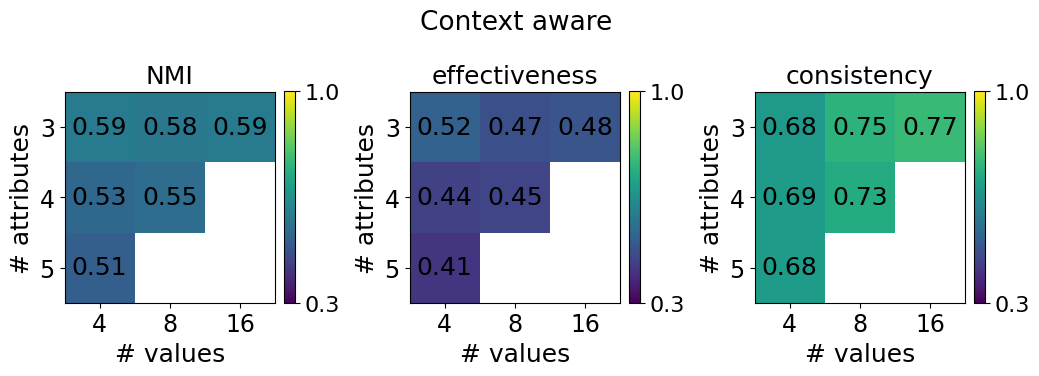

In [78]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.3, 1.0), figsize=(10.5, 3.5), 
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='Context aware ') # + test_mode

In [79]:
# means and stds
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    result_list = []
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        result_list.append((round(mean[idx], 3), round(sd[idx], 3)))
    entropy_dict[score] = result_list

In [80]:
entropies = [entropy_dict['NMI'], entropy_dict['effectiveness'], entropy_dict['consistency']]

# Row names and column names
row_names = ["D(3,4)", "D(3,8)", "D(3,16)", "D(4,4)", "D(4,8)", "D(5,4)"]
col_names = ["NMI", "effectiveness", 'consistency']

# Prepare the data for the DataFrames
data = []

# iterate over datasets
for i in range(len(entropies[0])):
    row = []
    # iterate over conditions
    for j in range(len(entropies)):
        formatted_value = f"{entropies[j][i][0]:.2f} $\\pm$ {entropies[j][i][1]:.2f}"
        row.append(formatted_value)
    data.append(row)

# Create DataFrames
df = pd.DataFrame(data, index=row_names, columns=col_names)

# Convert DataFrames to LaTeX tables
latex_table = df.to_latex(index=True, escape=False)

print(latex_table)


\begin{tabular}{llll}
\toprule
{} &              NMI &    effectiveness &      consistency \\
\midrule
D(3,4)  &  0.59 $\pm$ 0.03 &  0.52 $\pm$ 0.04 &  0.68 $\pm$ 0.01 \\
D(3,8)  &  0.58 $\pm$ 0.01 &  0.47 $\pm$ 0.02 &  0.75 $\pm$ 0.00 \\
D(3,16) &  0.59 $\pm$ 0.09 &  0.48 $\pm$ 0.11 &  0.77 $\pm$ 0.01 \\
D(4,4)  &  0.54 $\pm$ 0.03 &  0.44 $\pm$ 0.04 &  0.69 $\pm$ 0.01 \\
D(4,8)  &  0.55 $\pm$ 0.06 &  0.45 $\pm$ 0.07 &  0.73 $\pm$ 0.01 \\
D(5,4)  &  0.51 $\pm$ 0.02 &  0.41 $\pm$ 0.02 &  0.69 $\pm$ 0.01 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_85355/1335616103.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=True, escape=False)


#### Concept-dependent

In [83]:
# from generic to specific
entropies_hierarchical = [entropy_scores['NMI_hierarchical'], entropy_scores['effectiveness_hierarchical'], entropy_scores['consistency_hierarchical']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[3:6]):
    results = entropies_hierarchical[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


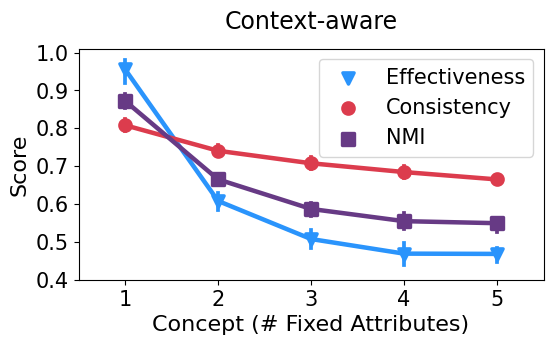

In [84]:
# plotting concept-level
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(n_runs):
        
        if test_interactions:
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores_' + test_mode + '.pkl', 'rb'))
        else:
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_hierarchical, 
                             'Effectiveness': effectiveness_hierarchical, 'Consistency': consistency_hierarchical}

all_hierarchical = {}
len_ds = len(entropy_dict_hierarchical['Effectiveness'])
all_hierarchical['metric'] = ['Effectiveness'] * len_ds + ['Consistency'] * len_ds + ['NMI'] * len_ds
all_hierarchical['value'] = (entropy_dict_hierarchical['Effectiveness'] + 
                             entropy_dict_hierarchical['Consistency'] +
                             entropy_dict_hierarchical['NMI'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette(['#2A94FC', '#DC3C4D', '#673A85']), scale=1.2)
plt.ylabel('Score', fontsize=16)
if context_unaware:
    plt.title('Context-unaware', fontsize=17, y=1.05)
else:
    plt.title('Context-aware', fontsize=17, y=1.05)
plt.ylim([0.4,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
plt.yticks(fontsize=15)
plt.xlabel('Concept (# Fixed Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='Information-theoretic score', title_fontsize=17)
plt.show()

#### Context-dependent

In [85]:
# from coarse to fine context
entropies_context_dep = [entropy_scores['NMI_context_dep'], entropy_scores['effectiveness_context_dep'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[6:9]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


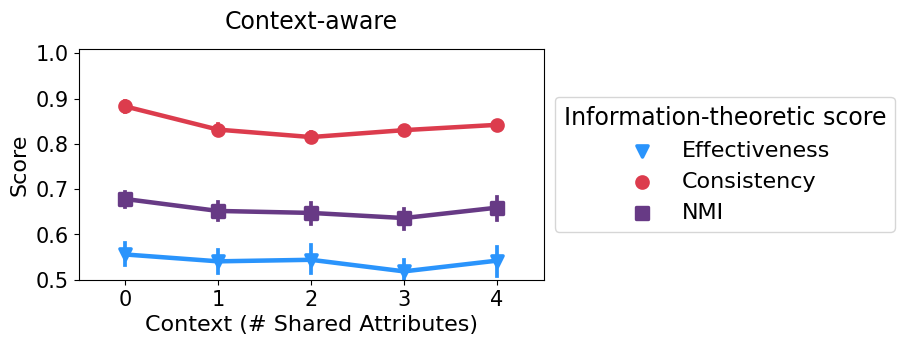

In [86]:
# plotting per context condition
data_list, run_list, level_list = [], [], []
NMI_context_dep, effectiveness_context_dep, consistency_context_dep = [], [], []

for d, data in enumerate(datasets):
    for run in range(n_runs):
        
        if test_interactions:
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores_' + test_mode + '.pkl', 'rb'))
        else:
            scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
            
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_context_dep.append(scores['normalized_mutual_info_context_dep'][l])
                effectiveness_context_dep.append(scores['effectiveness_context_dep'][l])
                consistency_context_dep.append(scores['consistency_context_dep'][l])
            except: 
                NMI_context_dep.append(np.nan)
                effectiveness_context_dep.append(np.nan)
                consistency_context_dep.append(np.nan)

entropy_dict_context_dep = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_context_dep, 
                             'Effectiveness': effectiveness_context_dep, 'Consistency': consistency_context_dep}

all_context_dep = {}
len_ds = len(entropy_dict_context_dep['Effectiveness'])
all_context_dep['metric'] = ['Effectiveness'] * len_ds + ['Consistency'] * len_ds +['NMI'] * len_ds 
all_context_dep['value'] = (entropy_dict_context_dep['Effectiveness'] + 
                             entropy_dict_context_dep['Consistency'] +
                             entropy_dict_context_dep['NMI']
                            )
all_context_dep['level'] = entropy_dict_context_dep['level'] * 3

plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette(['#2A94FC', '#DC3C4D', '#673A85']), 
                   scale=1.2)
plt.ylabel('Score', fontsize=16)
if context_unaware:
    plt.title('Context-unaware', fontsize=17, y=1.05)
else:
    plt.title('Context-aware', fontsize=17, y=1.05)
plt.ylim([0.5,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4])
plt.yticks(ticks=[0.5, 0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Context (# Shared Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='Information-theoretic score', title_fontsize=17)
plt.show()

In [36]:
df = pd.DataFrame(entropy_dict_context_dep)
means = df.groupby(['level']).mean()
stds = df.groupby(['level']).std()
print(means['NMI'].idxmax(), round(means['NMI'].max(), 2), round(stds['NMI'][means['NMI'].idxmax()], 2))
print(means['NMI'].idxmin(), round(means['NMI'].min(), 2), round(stds['NMI'][means['NMI'].idxmin()], 2))

1 0.68 0.05
4 0.64 0.05


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_85355/2867107125.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = df.groupby(['level']).mean()
/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_85355/2867107125.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds = df.groupby(['level']).std()


#### Concept x Context

In [37]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_concept_x_context[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])

#### NMI

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:145: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


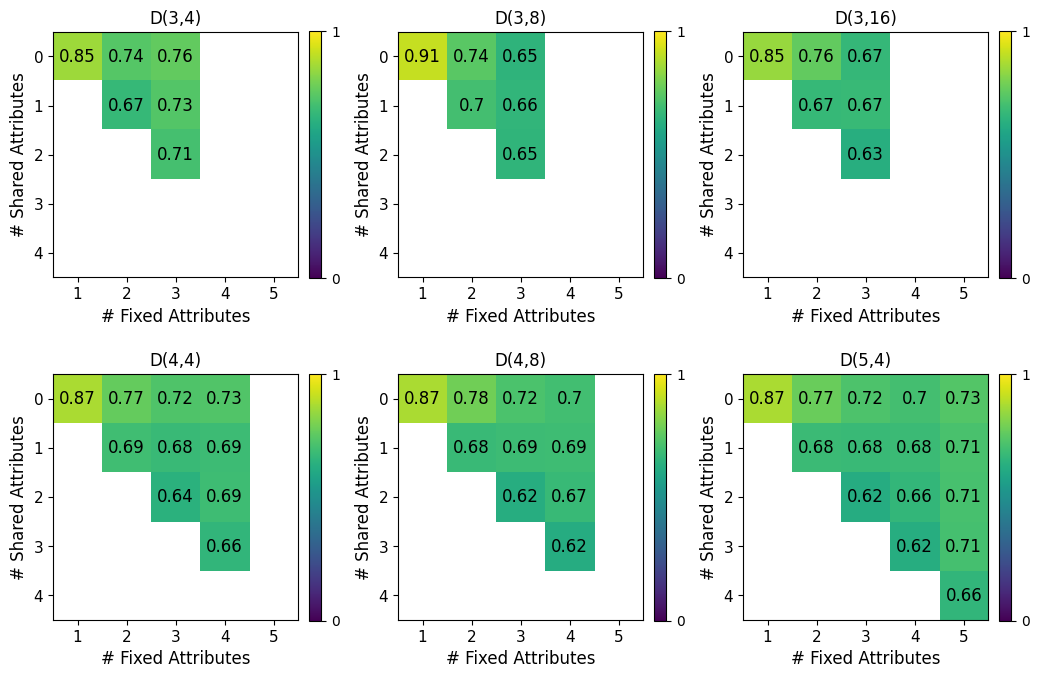

In [38]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(2,3), heatmap_size=(5,5),
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,1))

#### effectiveness

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:145: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


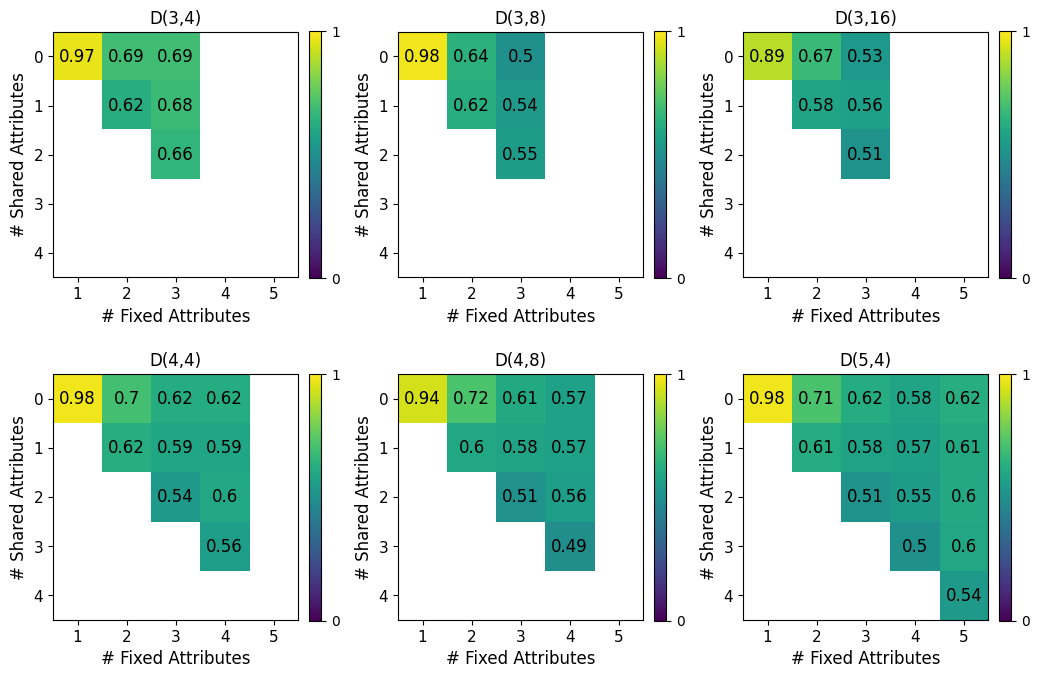

In [39]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='effectiveness', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), # plot_dims(2,3), heatmap (5,5)
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,1))

#### consistency

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:145: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


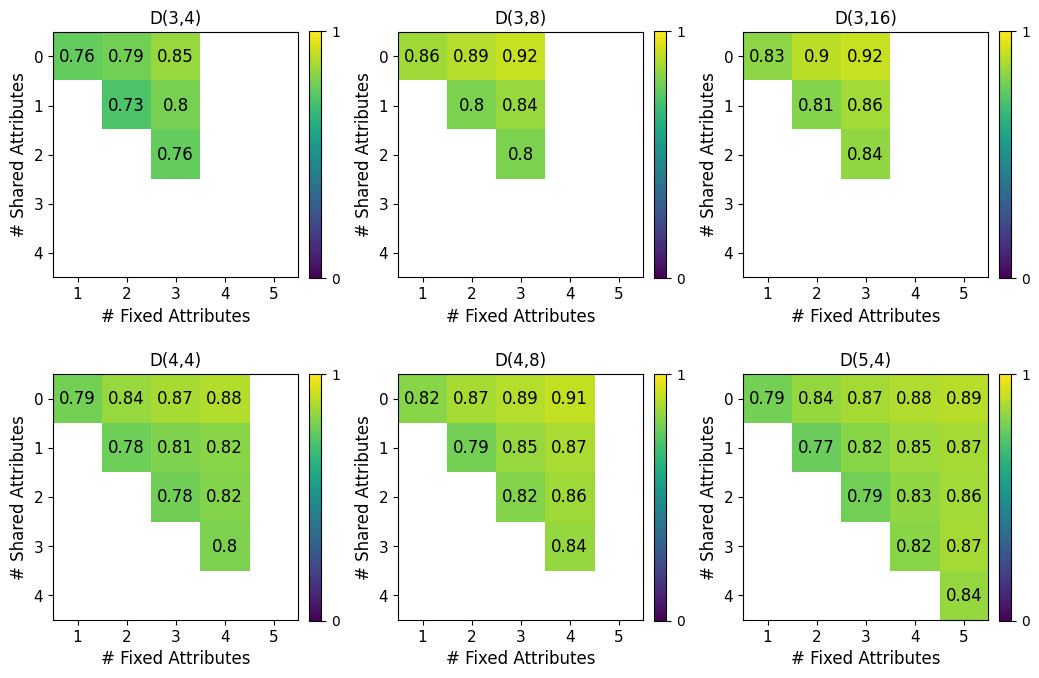

In [40]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='consistency', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), # plot_dims(2,3), heatmap (5,5)
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,1))

## Test interactions

In [41]:
test_interactions = True # whether scores should be calculated on test interactions
test_mode = 'test'

### Lexicon properties

#### Lexicon size and informativeness

In [42]:
setting = 'length_cost/context_aware/shared_context'
context_unaware = False

In [43]:
distance = 'manhattan' # 'manhattan' or 'euclidean'

lexprop_dict = {'dataset': [], 'run': [], 'lexicon informativeness': [], 'lexicon size': [], 'number of concepts': [], 'lexicon ratio': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        if test_interactions:
            lexprops = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/lexicon_properties_' + distance + '_' + test_mode + '.pkl', 'rb'))
        else:
            lexprops = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/lexicon_properties_' + distance + '.pkl', 'rb'))
            
        lexprop_dict['run'].append(run)
        lexprop_dict['dataset'].append(dataset)
        lexprop_dict['lexicon informativeness'].append(lexprops['lexicon informativeness'])
        lexprop_dict['lexicon size'].append(lexprops['lexicon size'])
        lexprop_dict['number of concepts'].append(lexprops['number of concepts'])
        lexprop_dict['lexicon ratio'].append((lexprops['lexicon size']/lexprops['number of concepts']))
            
df_lexprop = pd.DataFrame(lexprop_dict)

stats_lexprop = df_lexprop.groupby(['dataset'])['number of concepts'].agg(['mean', 'std']).reset_index()
stats_size = df_lexprop.groupby(['dataset'])['lexicon size'].agg(['mean', 'std']).reset_index()
stats_ratio = df_lexprop.groupby(['dataset'])['lexicon ratio'].agg(['mean', 'std']).reset_index()
stats_lexprop['number of concepts'] = stats_lexprop['mean'].astype(int)
stats_lexprop['lexicon size'] = stats_size['mean'].round(2).astype(str) + ' ± ' + stats_size['std'].round(2).astype(str)
stats_lexprop['lexicon ratio'] = stats_ratio['mean'].round(2).astype(str) + ' ± ' + stats_ratio['std'].round(2).astype(str)
stats_lexprop = stats_lexprop.drop(['mean', 'std'], axis=1)
print(stats_lexprop.to_latex(index=False))

\begin{tabular}{lrll}
\toprule
dataset &  number of concepts &   lexicon size & lexicon ratio \\
\midrule
 (3,16) &                 100 &   40.0 ± 17.39 &    0.4 ± 0.17 \\
  (3,4) &                 250 &  153.8 ± 32.34 &   0.62 ± 0.13 \\
  (3,8) &                1460 & 902.4 ± 116.91 &   0.62 ± 0.08 \\
  (4,4) &                1250 & 821.6 ± 117.53 &   0.66 ± 0.09 \\
  (4,8) &                 100 &    66.4 ± 24.5 &   0.66 ± 0.25 \\
  (5,4) &                 100 &    82.6 ± 12.3 &   0.83 ± 0.12 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_85355/3975579680.py:29: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_lexprop.to_latex(index=False))


In [44]:
stats_lexprop = df_lexprop.groupby(['dataset'])['lexicon informativeness'].agg(['mean', 'std']).reset_index()
stats_ratio = df_lexprop.groupby(['dataset'])['lexicon ratio'].agg(['mean', 'std']).reset_index()
stats_lexprop['lexicon ratio'] = stats_ratio['mean'].round(2).astype(str) + ' ± ' + stats_ratio['std'].round(2).astype(str)
stats_lexprop['lexicon informativeness'] = stats_lexprop['mean'].round(2).astype(str) + ' ± ' + stats_lexprop['std'].round(2).astype(str)
stats_lexprop = stats_lexprop.drop(['mean', 'std'], axis=1)
print(stats_lexprop.to_latex(index=False))

\begin{tabular}{lll}
\toprule
dataset & lexicon ratio & lexicon informativeness \\
\midrule
 (3,16) &    0.4 ± 0.17 &              3.9 ± 0.59 \\
  (3,4) &   0.62 ± 0.13 &             4.11 ± 0.13 \\
  (3,8) &   0.62 ± 0.08 &             3.49 ± 0.12 \\
  (4,4) &   0.66 ± 0.09 &             3.21 ± 0.25 \\
  (4,8) &   0.66 ± 0.25 &             3.98 ± 0.88 \\
  (5,4) &   0.83 ± 0.12 &             3.51 ± 0.84 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_85355/277258687.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_lexprop.to_latex(index=False))


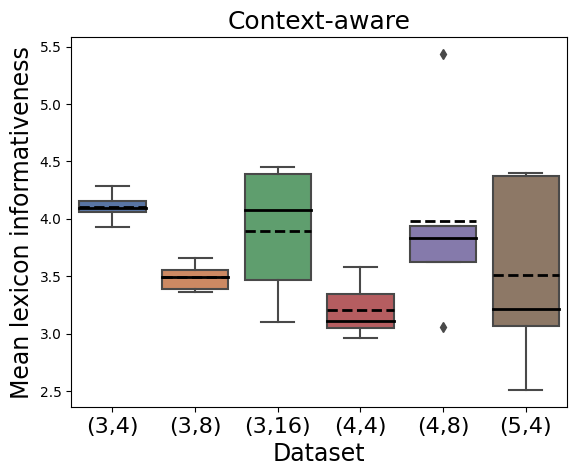

In [45]:
# Create a boxplot for each dataset
sns.boxplot(x='dataset', y='lexicon informativeness', data=df_lexprop, whis=1.5,
            palette='deep', showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
#g.set_titles(col_template="{col_name}", fontsize=50)
#g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
plt.xlabel(xlabel='Dataset', fontsize=17)
plt.ylabel(ylabel='Mean lexicon informativeness', fontsize=17)
plt.xticks(fontsize=16)
#plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=16)
#plt.ylim(0, 21)
if context_unaware:
    plt.title('Context-unaware', fontsize=18)
else:
    plt.title('Context-aware', fontsize=18)
plt.show()

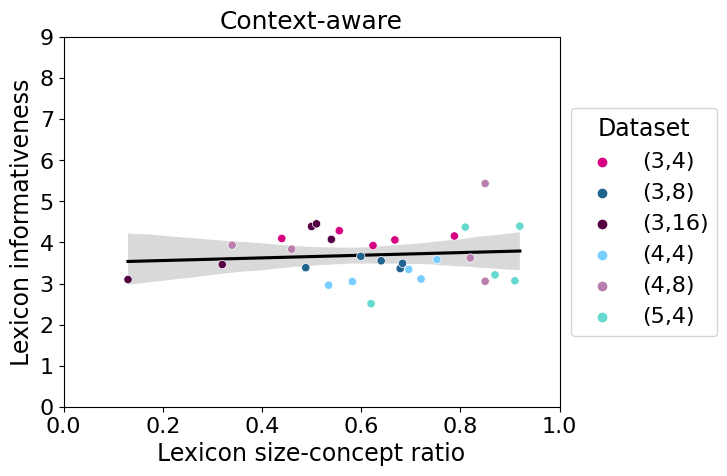

In [46]:
# Create a scatterplot with regression line
scatter = sns.scatterplot(x = 'lexicon ratio', y='lexicon informativeness', data=df_lexprop, hue='dataset', zorder=2,
                              palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]))
reg = sns.regplot(x = 'lexicon ratio', y = 'lexicon informativeness', data=df_lexprop, scatter=False, color="black")
lines = reg.get_lines()
for line in lines:
    line.set_zorder(1)  # Regression line behind
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='Dataset', title_fontsize=17)
plt.xlabel(xlabel='Lexicon size-concept ratio', fontsize=17)
plt.ylabel(ylabel='Lexicon informativeness', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 9)
plt.xlim(0, 1)
if context_unaware:
    plt.title('Context-unaware', fontsize=18)
else:
    plt.title('Context-aware', fontsize=18)
plt.show()

### Message length

#### Message lengths per concept hierarchy level

In [47]:
setting = 'length_cost/context_unaware/shared_context'
context_unaware = True

In [48]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):

        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        if not test_interactions:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        else:
            ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical_' + test_mode + '.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

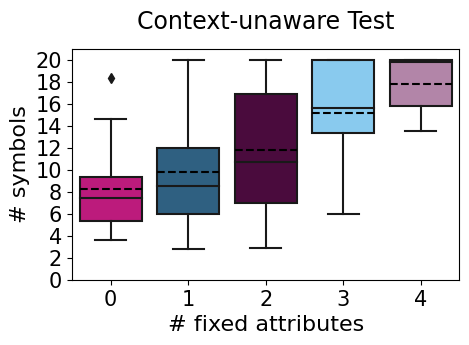

In [49]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]), showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=1.5))
plt.yticks(fontsize=15, ticks=[0,2,4,6,8,10,12,14,16,18,20])
plt.xticks(fontsize=15)
plt.ylim(0,21)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
if context_unaware:
    plt.title('Context-unaware Test', fontsize=17, y=1.05)
else:
    plt.title('Context-aware Test', fontsize=17, y=1.05)
plt.show()

In [50]:
df = pd.DataFrame(ml_dict)
agg = df.groupby('level').agg({'message length': ['mean', 'min', 'max']})
agg

message length               
                mean     min    max
level                              
0           8.267333   3.650  18.38
1           9.823080   2.833  20.00
2          11.757167   2.857  20.00
3          15.147933   6.000  20.00
4          17.800000  13.500  20.00

### Symbol redundancy

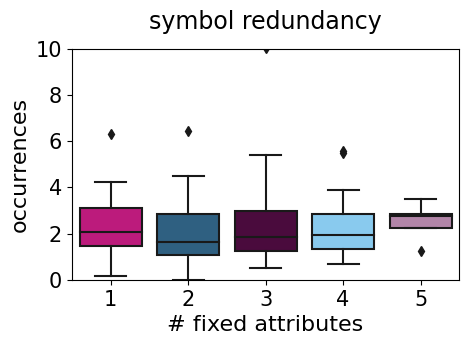

In [51]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/symbol_redundancy_test.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]))
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5], fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,10)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

### Frequency rank

In [52]:
# comparison with English and Arabic
df_english = pd.read_csv('analysis/eng_news_2024_10K-words.csv', index_col=0)
df_arabic = pd.read_csv('analysis/ara_news_2022_10K-words_subset.csv', index_col=0)

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language['relative frequency'] = language['frequency'] / sum(language['frequency'])
/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language['relative frequency'] = language['frequency'] / sum(language['frequency'])


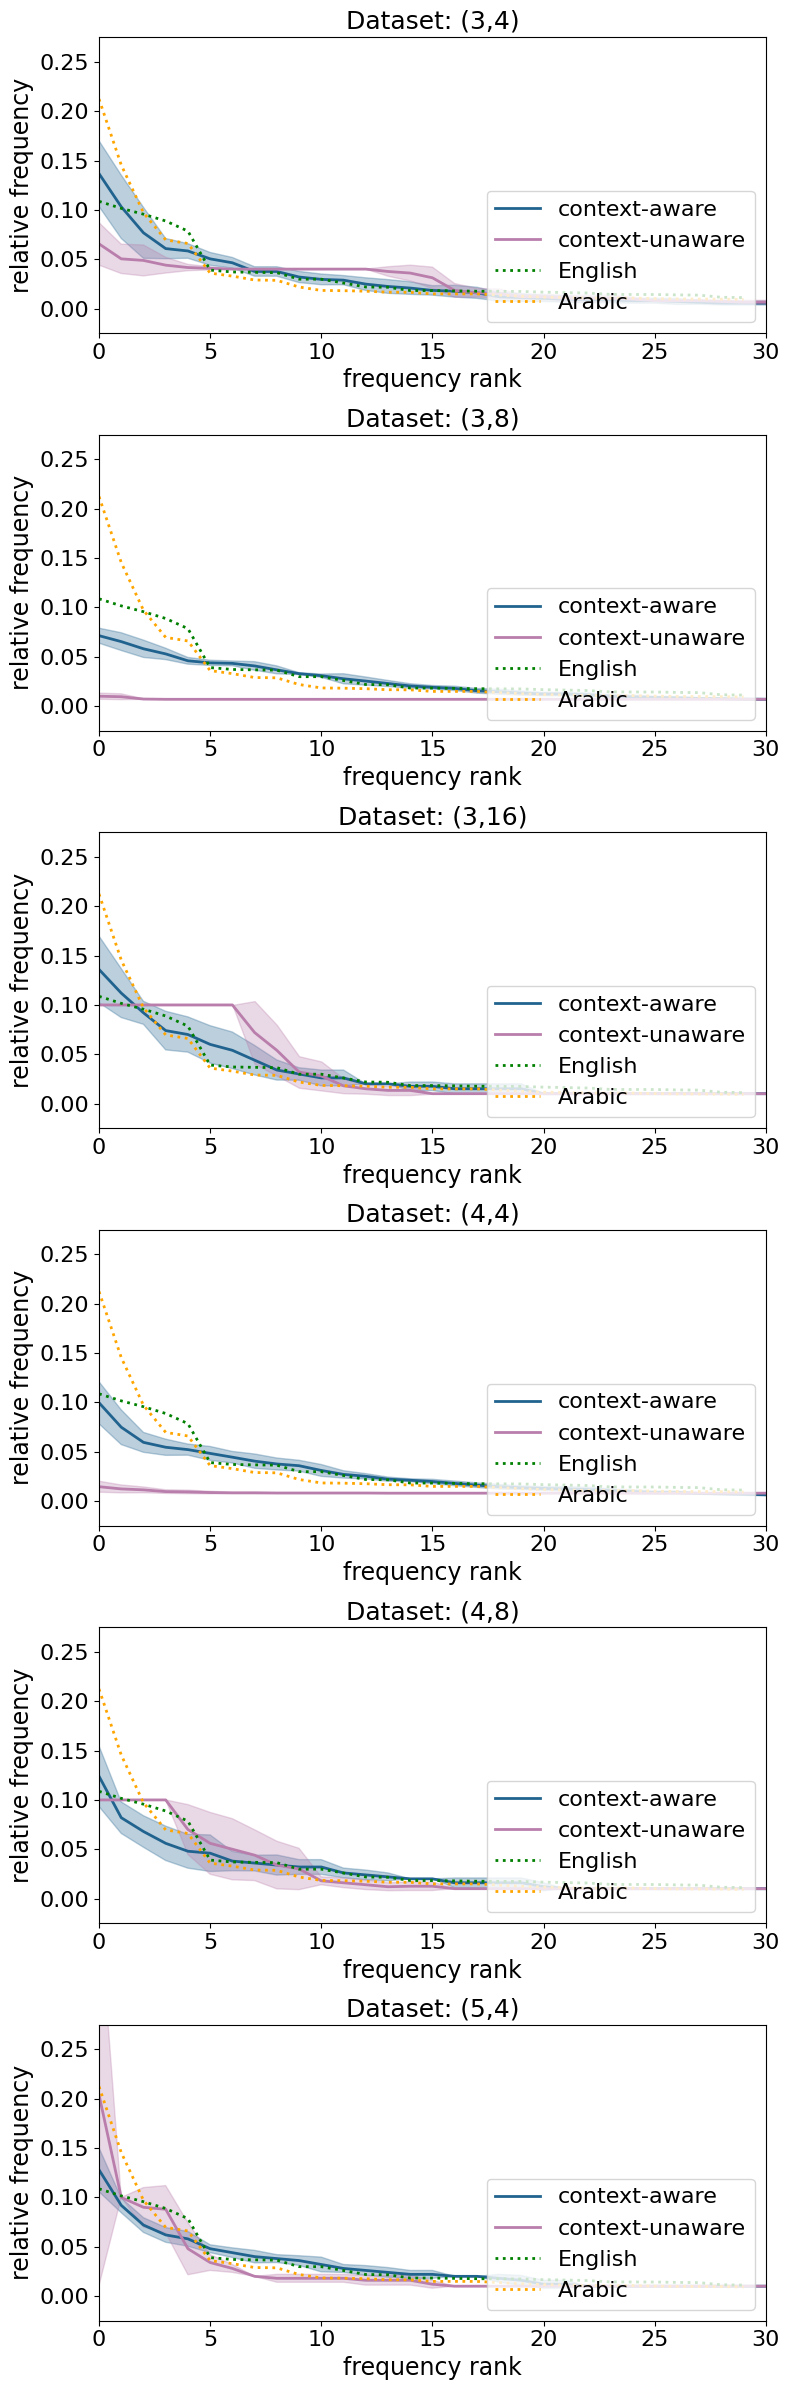

In [53]:
plot_frequency(paths, ["length_cost/context_aware/shared_context", "length_cost/context_unaware/shared_context"], n_runs, n_values, datasets, n_epochs=0, int='test', std=True, labels=['context-aware', 'context-unaware', 'English', 'Arabic'], frequency='message', fontsize=16, color=["#21638f", "#b97eac",'green','orange'], ylim=(-0.025, 0.275), yticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25], xlim=(0,30), natural_language=[df_english.iloc[:30], df_arabic.iloc[:30]], linewidth=2)

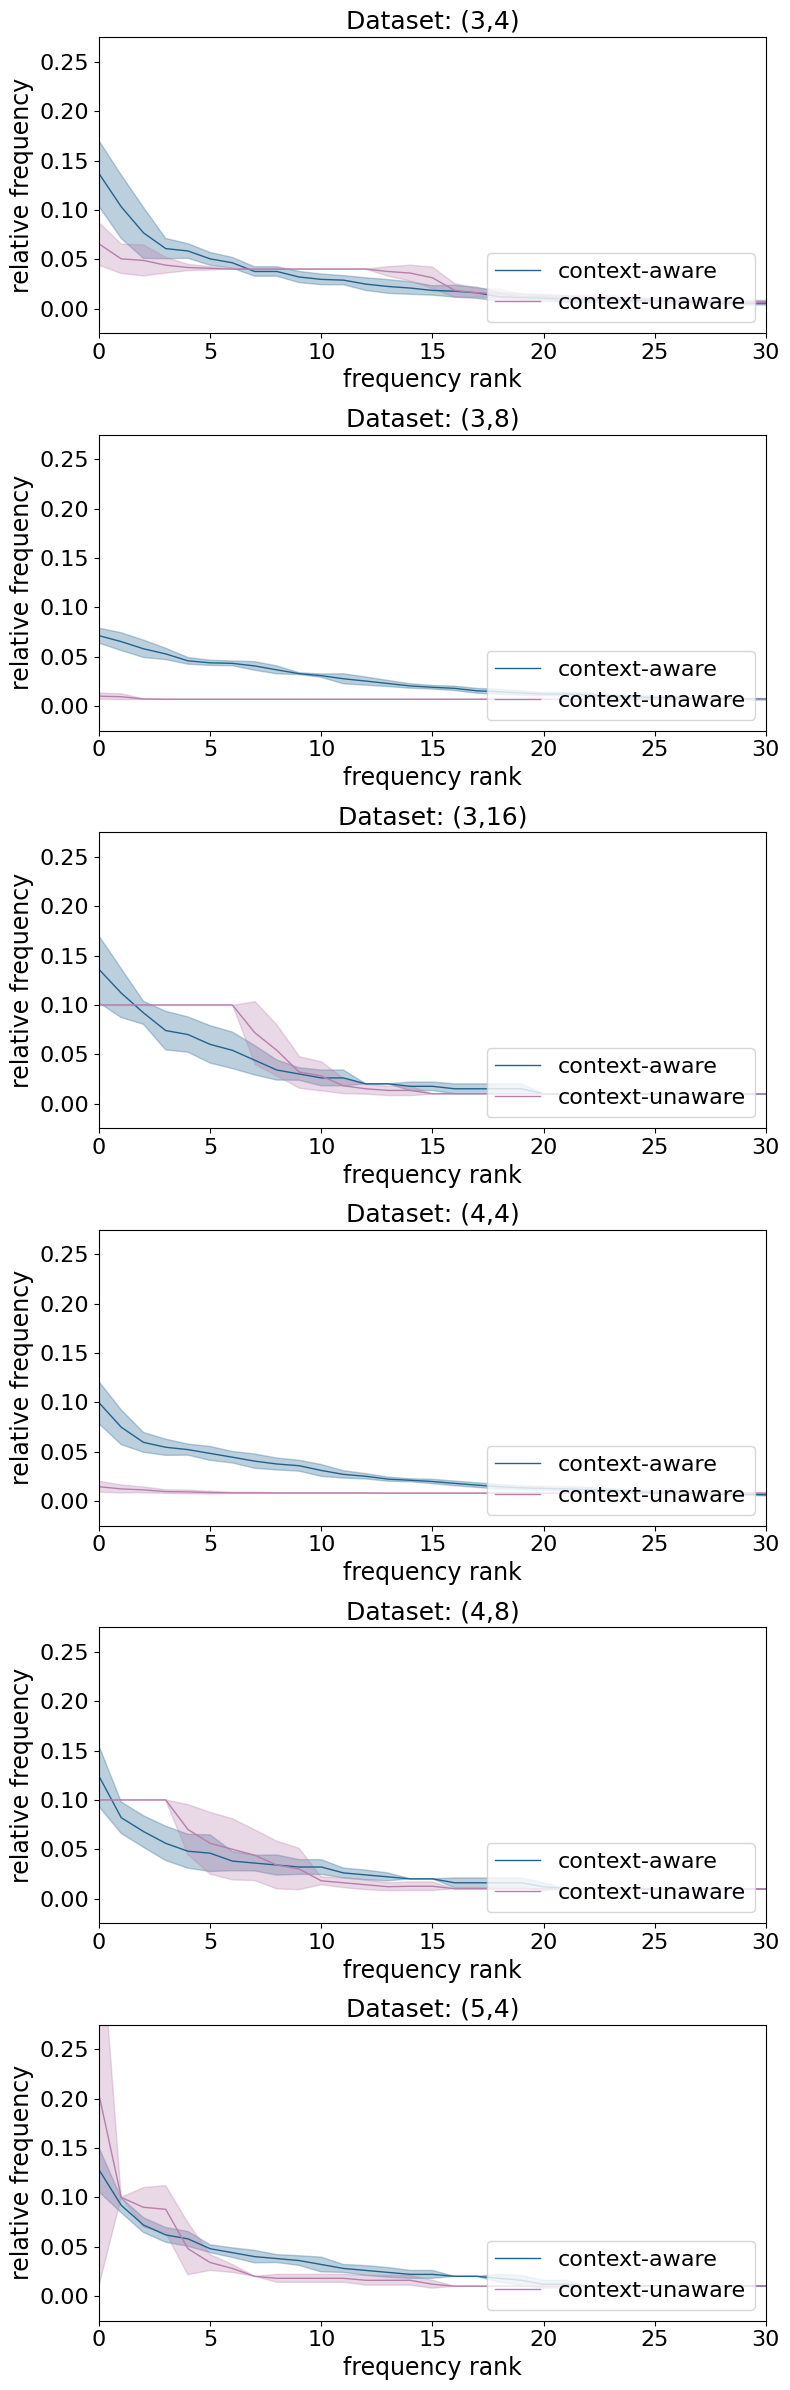

In [54]:
plot_frequency(paths, ["length_cost/context_aware/shared_context", "length_cost/context_unaware/shared_context"], n_runs, n_values, datasets, n_epochs=0, int='test', std=True, labels=['context-aware', 'context-unaware'], fontsize=16, color=["#21638f", "#b97eac"], ylim=(-0.025, 0.275), yticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25], xlim=(0,30))

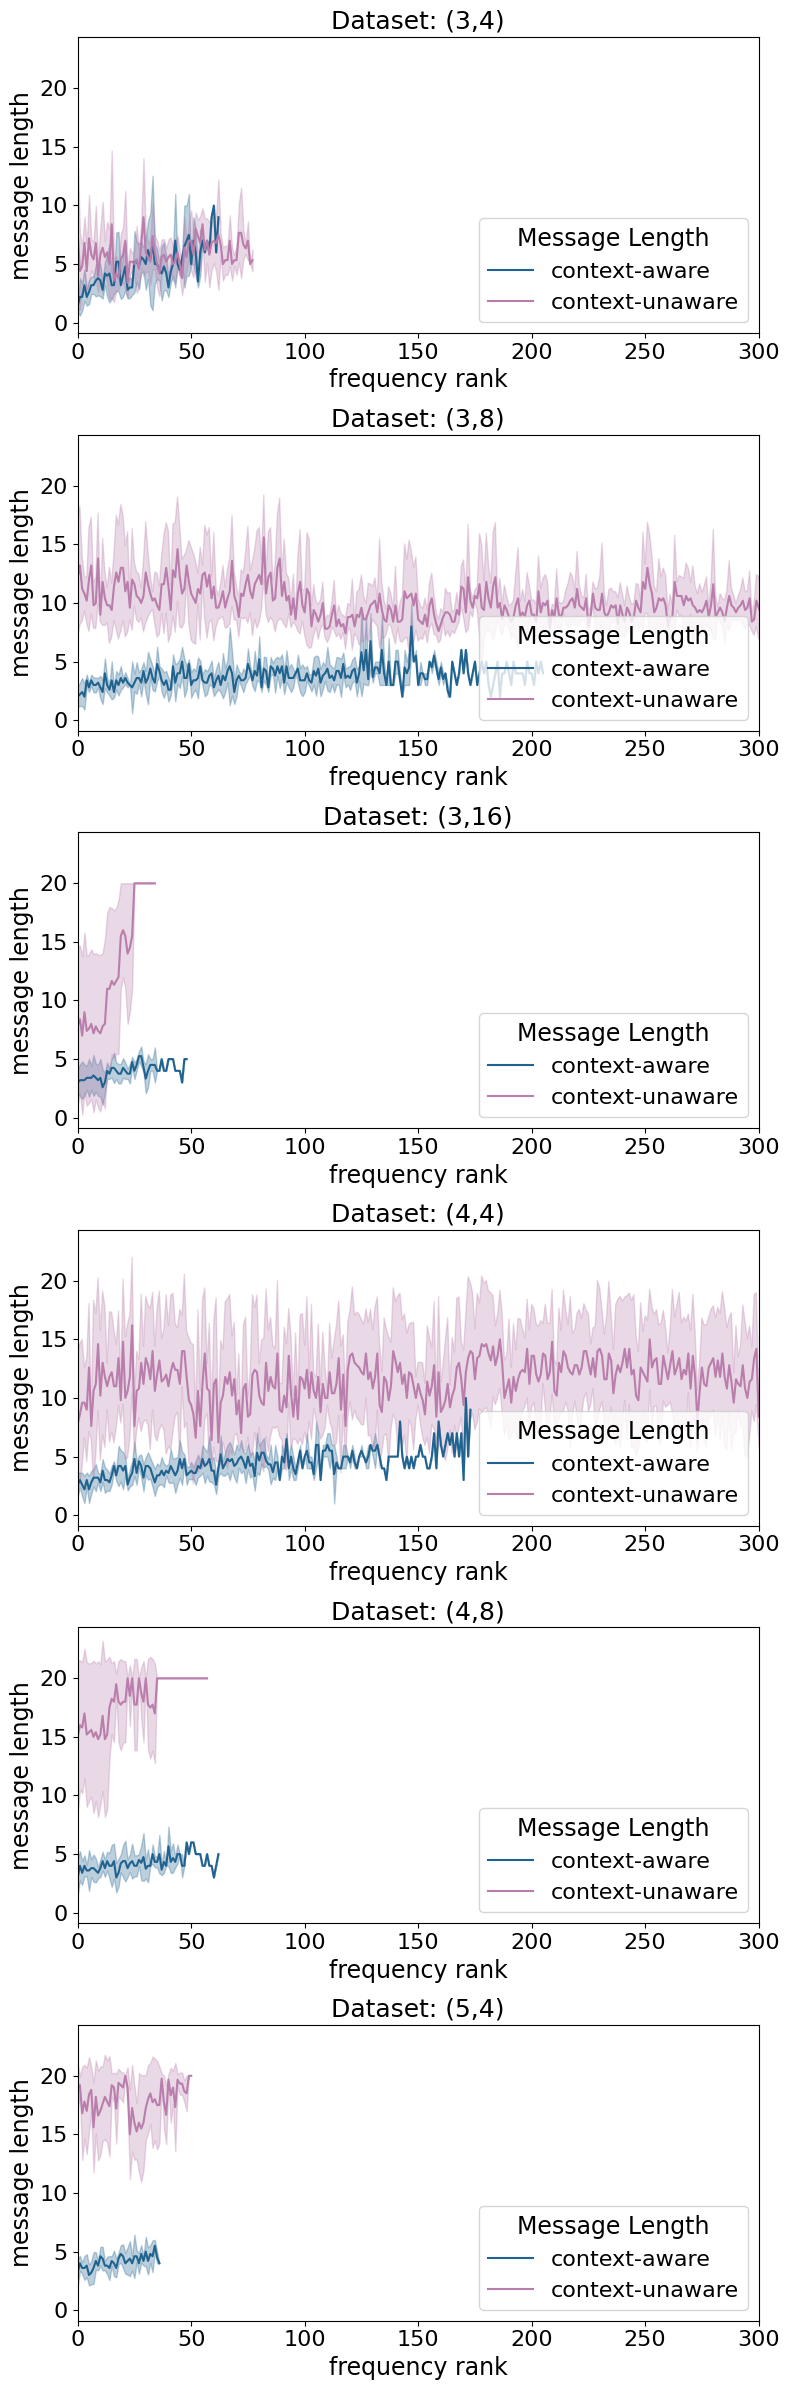

In [55]:
plot_frequency_x_message_length(paths, ["length_cost/context_aware/shared_context", "length_cost/context_unaware/shared_context"], n_runs, n_values, datasets, n_epochs=0, std=True, int='test', labels=['context-aware', 'context-unaware'], fontsize=16, color=["#21638f", "#b97eac"], xlim=(0,300))

### Entropy scores

In [56]:
entropy_scores = load_entropies(paths, context_unaware=context_unaware, length_cost=length_cost, sampled_context=sampled_context, test_interactions=test_interactions, test_mode=test_mode, hierarchical=hierarchical, shared_context=shared_context, verbose=False) # 
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/load_results.py:654: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


#### General

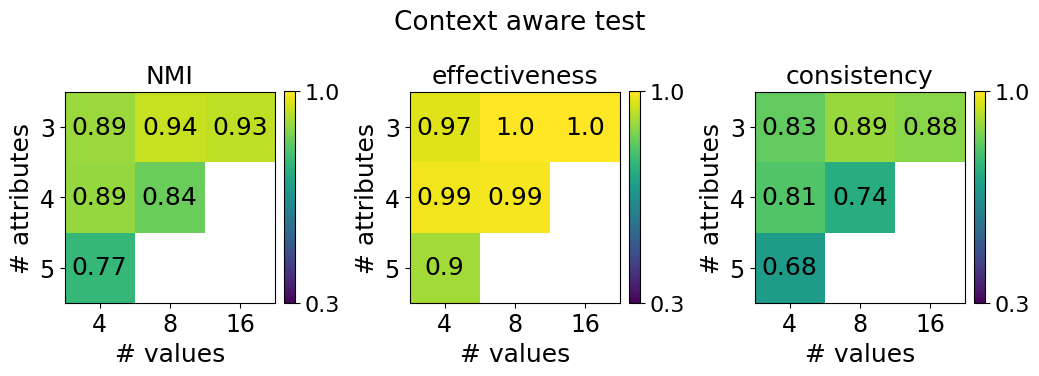

In [57]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.3, 1.0), figsize=(10.5, 3.5), 
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='Context aware ' + test_mode)

In [58]:
# means and stds
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict

{'(3,4)NMI': (0.895, 0.015),
 '(3,8)NMI': (0.941, 0.003),
 '(3,16)NMI': (0.932, 0.039),
 '(4,4)NMI': (0.889, 0.007),
 '(4,8)NMI': (0.841, 0.067),
 '(5,4)NMI': (0.766, 0.077),
 '(3,4)effectiveness': (0.967, 0.031),
 '(3,8)effectiveness': (0.998, 0.002),
 '(3,16)effectiveness': (1.0, 0.0),
 '(4,4)effectiveness': (0.986, 0.009),
 '(4,8)effectiveness': (0.99, 0.02),
 '(5,4)effectiveness': (0.902, 0.181),
 '(3,4)consistency': (0.833, 0.011),
 '(3,8)consistency': (0.891, 0.006),
 '(3,16)consistency': (0.875, 0.068),
 '(4,4)consistency': (0.809, 0.017),
 '(4,8)consistency': (0.736, 0.106),
 '(5,4)consistency': (0.683, 0.021)}

#### Concept x Context

In [59]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_concept_x_context[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])

#### NMI

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:145: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


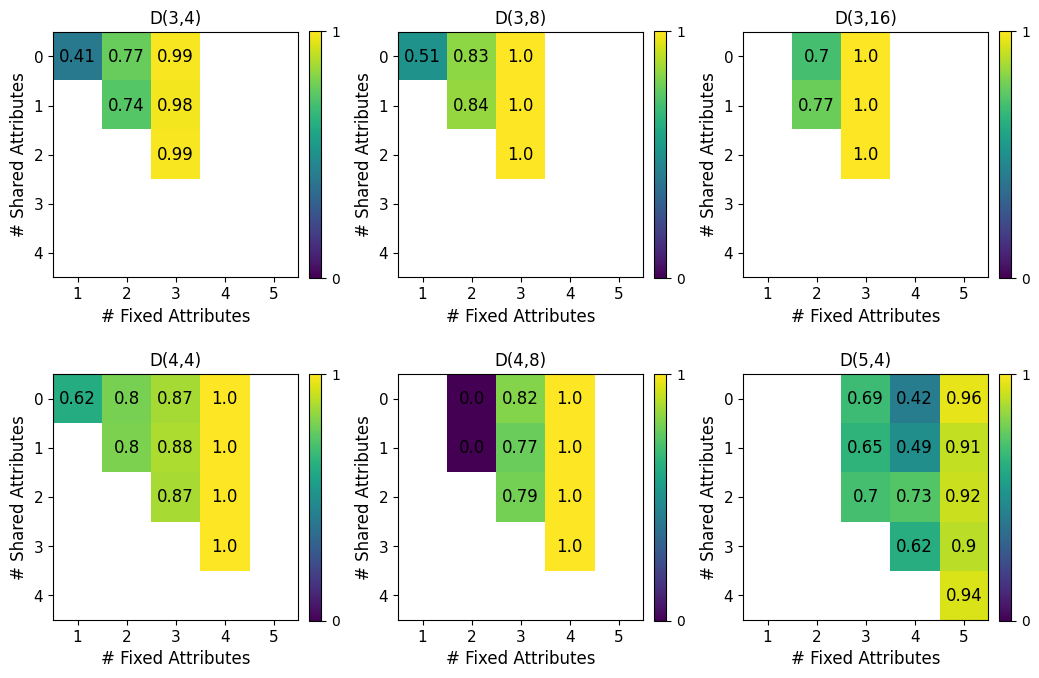

In [60]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), # plot_dims(2,3), heatmap (5,5)
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,1))

#### effectiveness

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:145: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


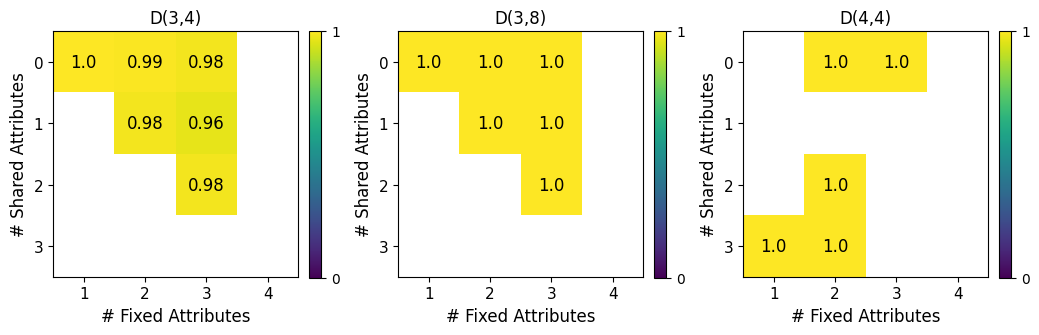

In [61]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='effectiveness', mode='mean', plot_dims=(1,3), heatmap_size=(4,4), # plot_dims(2,3), heatmap (5,5)
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,1), titles=('D(3,4)', 'D(3,8)', 'D(4,4)'))

#### consistency

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:145: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


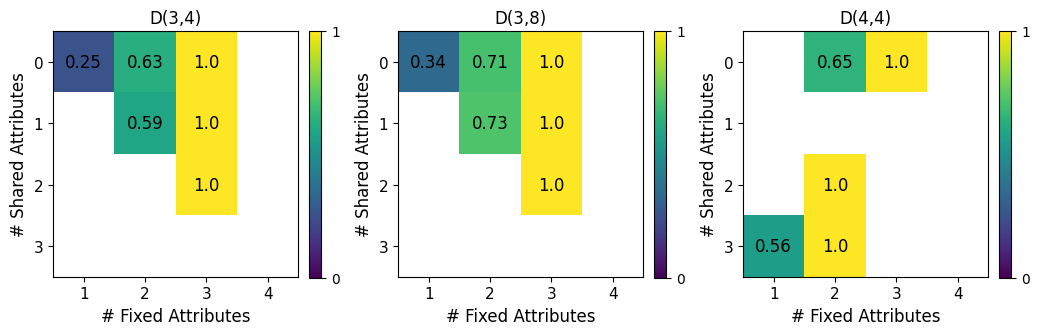

In [62]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='consistency', mode='mean', plot_dims=(1,3), heatmap_size=(4,4), # plot_dims(2,3), heatmap (5,5)
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,1), titles=('D(3,4)', 'D(3,8)', 'D(4,4)'))

## Compositionality

In [63]:
test_interactions = True

In [64]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_specific, posdis_specific, bosdis_specific = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_generic, posdis_generic, bosdis_generic = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        
        if not test_interactions:
            topsim_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
            #disent_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        else:
            topsim_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final_' + test_mode + '.pkl', 'rb'))
            #disent_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis_' + test_mode + '.pkl', 'rb'))
        
        topsim[d, run] = topsim_score['topsim_train']
        #posdis[d, run] = disent_score['posdis']
        #bosdis[d, run] = disent_score['bosdis']
        topsim_specific[d, run] = topsim_score['topsim_specific_train']
        #posdis_specific[d, run] = disent_score['posdis_specific']
        #bosdis_specific[d, run] = disent_score['bosdis_specific']
        topsim_generic[d, run] = topsim_score['topsim_generic_train']
        #posdis_generic[d, run] = disent_score['posdis_generic']
        #bosdis_generic[d, run] = disent_score['bosdis_generic']

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,4)_game_size_10_vsf_0/length_cost/context_unaware/shared_context/0/topsim_final_test.pkl'

### Topsim

In [30]:
for i, d in enumerate(datasets):
    print(d, "topsim:", round(np.mean(topsim[i]), 3), "sd", round(np.std(topsim[i]), 2))

(3,4) topsim: 0.269 sd 0.04
(3,8) topsim: 0.181 sd 0.02
(3,16) topsim: 0.098 sd 0.02
(4,4) topsim: 0.329 sd 0.04
(4,8) topsim: 0.204 sd 0.06
(5,4) topsim: 0.255 sd 0.03


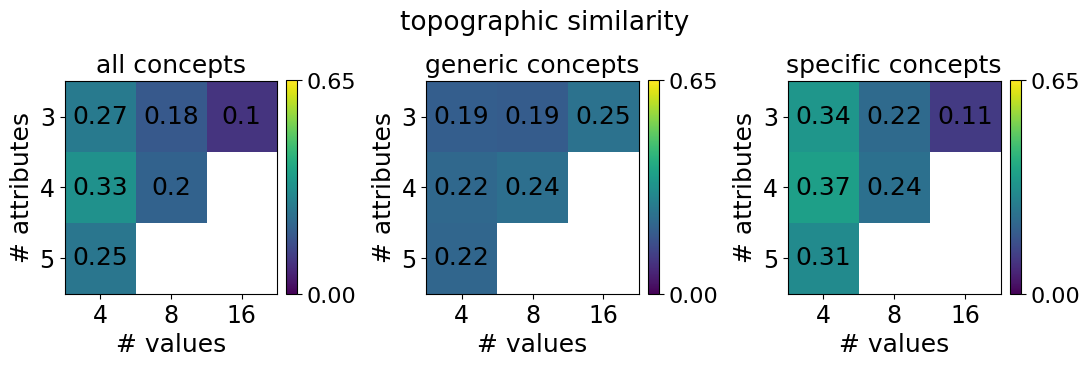

In [31]:
plot_heatmap([topsim, topsim_generic, topsim_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5), 
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='topographic similarity', suptitle_position=1.)

#### Topographic similarity over time

In [32]:
topsim_over_time = {}

for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/topsim_over_time.pkl', 'rb'))
            
        topsim_over_time[d][run] = scores
            
plt.plot(topsim_over_time[0][0])
round(max(topsim_over_time[0][0]) - min(topsim_over_time[0][0]), 3)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,4)_game_size_10_vsf_0/length_cost/context_unaware/0/topsim_over_time.pkl'

### Posdis

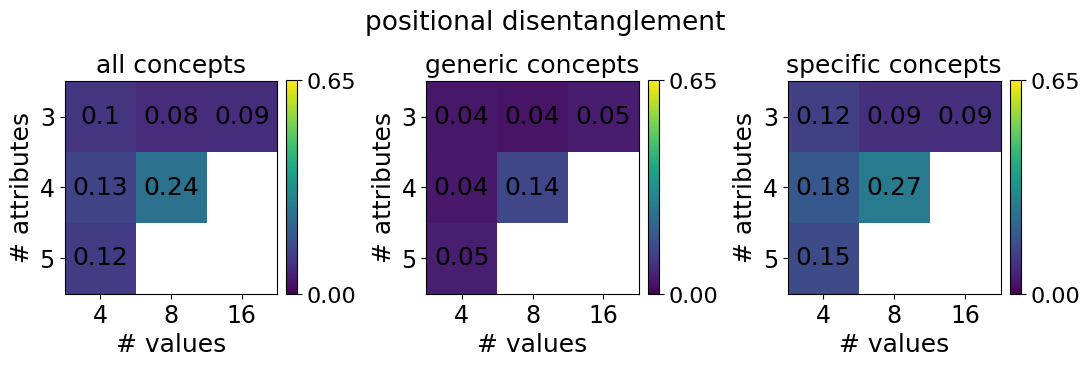

In [44]:
plot_heatmap([posdis, posdis_generic, posdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='positional disentanglement', suptitle_position=1.)

In [52]:
posdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(n_runs):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_scores.pkl', 'rb')))
    posdis.append(sublist)

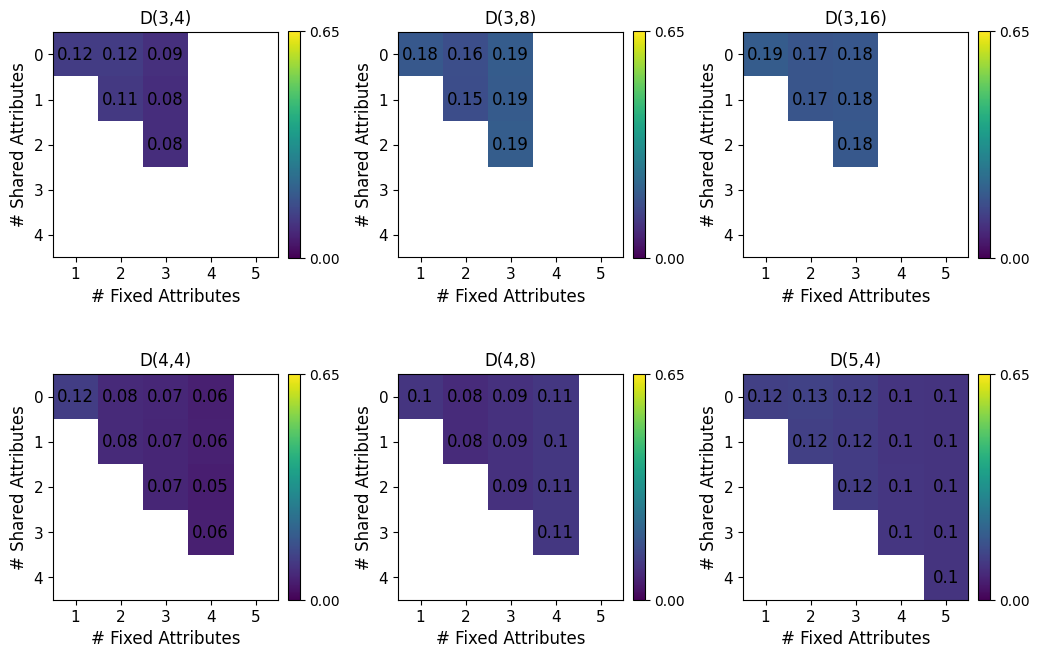

In [53]:
plot_heatmap_concept_x_context(posdis, score='posdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Bosdis

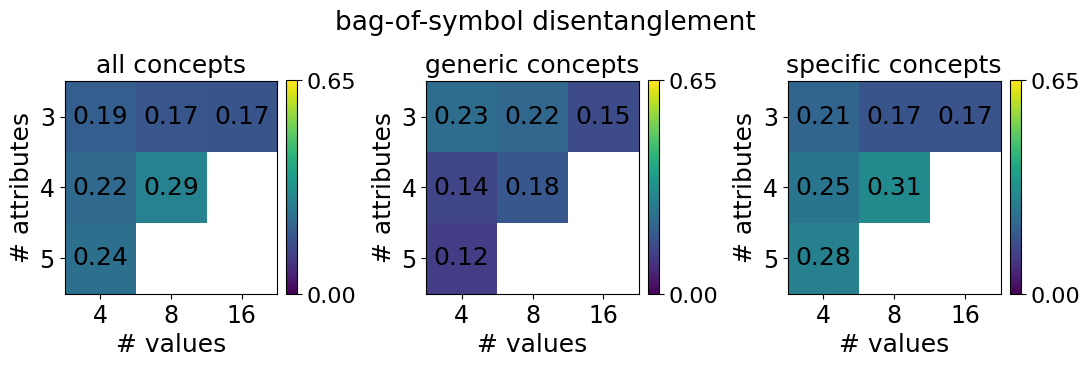

In [48]:
plot_heatmap([bosdis, bosdis_generic, bosdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='bag-of-symbol disentanglement', suptitle_position=1.)

In [49]:
bosdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(n_runs):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/bosdis_scores.pkl', 'rb')))
    bosdis.append(sublist)

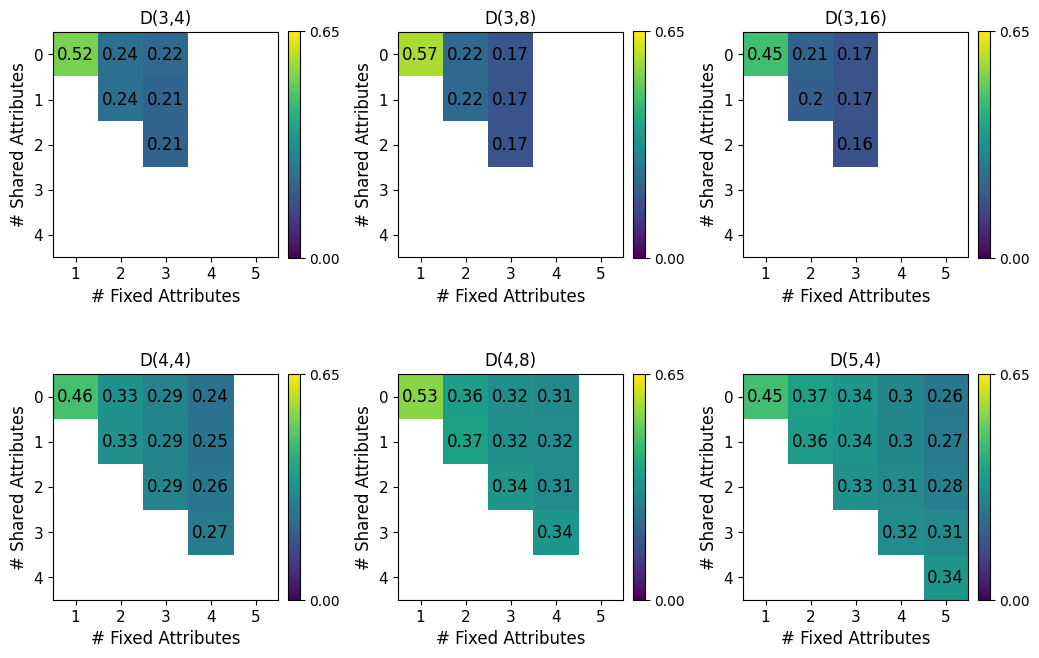

In [50]:
plot_heatmap_concept_x_context(bosdis, score='bosdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Compositionality per dataset

In [35]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        
        topsim = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            #for data in ['all', 'concrete']: 
            for data in ['all']:
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

In [199]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.ylim(0, 0.65)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

NameError: name 'compositionality_scores' is not defined

## Errors

In [200]:
validation = True # set to false if training interaction should be used
setting = 'standard'

In [57]:
import torch
from utils.analysis_from_interaction import *

In [201]:
def error_analysis(datasets, paths, setting, n_epochs, n_values, validation=True):
    """
    goes through interactions, retrieves concept and context conditions and counts errors, 
    i.e. incorrectly classified objects (by the receiver)
    """
    all_error_concepts = {}
    all_error_contexts = {}
    all_error_concept_x_context = {}
    all_false_positives = {}
    all_false_negatives = {}
    all_total_errs = {}

    all_acc_concept_x_context = {}

    all_total_concepts = {}
    all_total_contexts = {}
    all_total_concept_x_context = {}

    # go through all datasets
    for i, d in enumerate(datasets):
        print(i, d)
        error_concepts = {}
        error_contexts = {}
        error_concept_x_context = {}
        false_positives = {}
        false_negatives = {}
        total_errs = {}
        acc_concept_x_context = {}
        # select first run
        path_to_run = paths[i] + '/' + str(setting) + '/' + str(0) + '/'
        path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
        if validation:
            interaction = torch.load(path_to_interaction_val)
        else:
            interaction = torch.load(path_to_interaction_train)

        total_concepts = obtain_concept_counts(interaction.sender_input, n_values[i])

        total_contexts = obtain_context_counts(interaction.sender_input, n_values[i])

        total_concept_x_context = obtain_concept_x_context_counts(interaction.sender_input, n_values[i])

        for j in range(len(interaction.sender_input)):
            receiver_pred = (interaction.receiver_output[j][-1] > 0).float()  # use last symbol of message

            (objects, fixed) = get_fixed_vectors(interaction.sender_input, n_values[i], j)
            concept_str = str(int(sum(fixed[0])))

            context_conds = get_context_cond(interaction.sender_input, n_values[i], j, objects, fixed)
            context_str = str(context_conds[0])
            concept_x_context_str = (context_conds[0], int(sum(fixed[0]) - 1))
            
            # check if receiver has classified all objects correctly as targets or distractors
            if not torch.equal(receiver_pred, interaction.labels[j]):
                if concept_str in error_concepts:
                    error_concepts[concept_str] += 1
                else:
                    error_concepts[concept_str] = 1

                if context_str in error_contexts:
                    error_contexts[context_str] += 1
                else:
                    error_contexts[context_str] = 1

                if concept_x_context_str in error_concept_x_context:
                    error_concept_x_context[concept_x_context_str] += 1
                else:
                    error_concept_x_context[concept_x_context_str] = 1
                    
                # calculate false positives and false negatives
                num_false_pos = 0
                num_false_neg = 0
                errors = receiver_pred - interaction.labels[j]
                for error in errors:
                    # false positives
                    if error > 0:
                        num_false_pos += 1
                    # false negatives
                    elif error < 0:
                        num_false_neg += 1
                if concept_x_context_str in false_positives:
                    false_positives[concept_x_context_str] += num_false_pos
                else:
                    false_positives[concept_x_context_str] = num_false_pos
                if concept_x_context_str in false_negatives:
                    false_negatives[concept_x_context_str] += num_false_neg
                else:
                    false_negatives[concept_x_context_str] = num_false_neg
                if concept_x_context_str in total_errs:
                    total_errs[concept_x_context_str] += (num_false_pos + num_false_neg)
                else:
                    total_errs[concept_x_context_str] = (num_false_pos + num_false_neg)
                #print("per round", error_concept_x_context)
                #print("total", total_errs)

            # check if receiver has classified some objects correctly as targets or distractors
            # (this is how the accuracy is calculated during training)
            if concept_x_context_str in acc_concept_x_context:
                acc_concept_x_context[concept_x_context_str] += (
                    (receiver_pred == interaction.labels[j]).float().mean().numpy())
            else:
                acc_concept_x_context[concept_x_context_str] = (
                        receiver_pred == interaction.labels[j]).float().mean().numpy()
                
        #print(error_concept_x_context)
        #print("total errs", total_errs)
        #print("total cxc", total_concept_x_context)

        all_error_concepts[d] = error_concepts
        all_error_contexts[d] = error_contexts
        all_error_concept_x_context[d] = error_concept_x_context
        all_false_positives[d] = false_positives
        all_false_negatives[d] = false_negatives
        all_total_errs[d] = total_errs

        all_acc_concept_x_context[d] = acc_concept_x_context

        all_total_concepts[d] = total_concepts
        all_total_contexts[d] = total_contexts
        all_total_concept_x_context[d] = total_concept_x_context

    return (all_error_concepts, all_error_contexts, all_error_concept_x_context, 
            all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
            all_total_concepts, all_total_contexts, all_total_concept_x_context)

In [202]:
(all_error_concepts, all_error_contexts, all_error_concept_x_context, 
 all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
 all_total_concepts, all_total_contexts, all_total_concept_x_context) = error_analysis(datasets, paths, setting, n_epochs, n_values, validation)

0 (3,4)
1 (3,8)
2 (3,16)
3 (4,4)
4 (4,8)
5 (5,4)


In [101]:
err_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_error_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_error_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    err_ratio_concept_x_context[d] = ratio_concept_x_context

In [158]:
all_total_errs['(3,4)'] # how many objects were classified incorrectly per condition

{(2, 2): 92, (0, 1): 17, (1, 1): 60}

In [164]:
all_error_concept_x_context['(3,4)'] # how often data in a specific condition was classified incorrectly

{(2, 2): 34, (0, 1): 4, (1, 1): 16}

In [159]:
all_total_concept_x_context['(3,4)'] # how often the specific concept x context condition is present in the interaction

{(0, 2): 118, (2, 2): 144, (1, 2): 121, (1, 1): 101, (0, 1): 91, (0, 0): 21}

In [149]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    print(d)
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        print(concept_x_context)
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / #* (all_total_errs[d][concept_x_context] / 
            all_total_concept_x_context[d][concept_x_context], 4)
            #print(all_false_positives[d][concept_x_context] / all_total_errs[d][concept_x_context])
            print(all_total_errs[d][concept_x_context], all_total_concept_x_context[d][concept_x_context], all_total_errs[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
            print(all_false_positives[d][concept_x_context], all_false_positives[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

(3,4)
(0, 2)
(2, 2)
92 144 0.6388888888888888
92 0.6388888888888888
(1, 2)
(1, 1)
60 101 0.594059405940594
23 0.22772277227722773
(0, 1)
17 91 0.18681318681318682
0 0.0
(0, 0)
(3,8)
(1, 1)
190 402 0.472636815920398
40 0.09950248756218906
(0, 2)
1 1022 0.0009784735812133072
1 0.0009784735812133072
(2, 2)
370 1025 0.36097560975609755
370 0.36097560975609755
(1, 2)
12 986 0.012170385395537525
12 0.012170385395537525
(0, 1)
117 399 0.2932330827067669
0 0.0
(0, 0)
26 44 0.5909090909090909
0 0.0
(3,16)
(1, 2)
303 8253 0.036713922210105415
133 0.016115351993214587
(2, 2)
4144 8132 0.5095917363502214
3954 0.48622725036891296
(0, 1)
739 1562 0.4731113956466069
10 0.006402048655569782
(0, 2)
134 8168 0.016405484818805095
4 0.0004897159647404506
(1, 1)
1150 1561 0.7367072389493914
456 0.29212043561819345
(0, 0)
226 92 2.4565217391304346
11 0.11956521739130435
(4,4)
(1, 3)
(1, 2)
71 495 0.14343434343434344
0 0.0
(3, 3)
283 526 0.5380228136882129
283 0.5380228136882129
(1, 1)
56 188 0.2978723404255

In [203]:
false_objects_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_total_errs[d]:
            ratio_concept_x_context[concept_x_context] = round(all_total_errs[d][concept_x_context] / (all_total_concept_x_context[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_objects_ratio[d] = ratio_concept_x_context

In [194]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

In [195]:
false_negatives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_negatives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_negatives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_negatives_ratio[d] = ratio_concept_x_context

In [94]:
acc_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_acc_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_acc_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    acc_ratio_concept_x_context[d] = ratio_concept_x_context

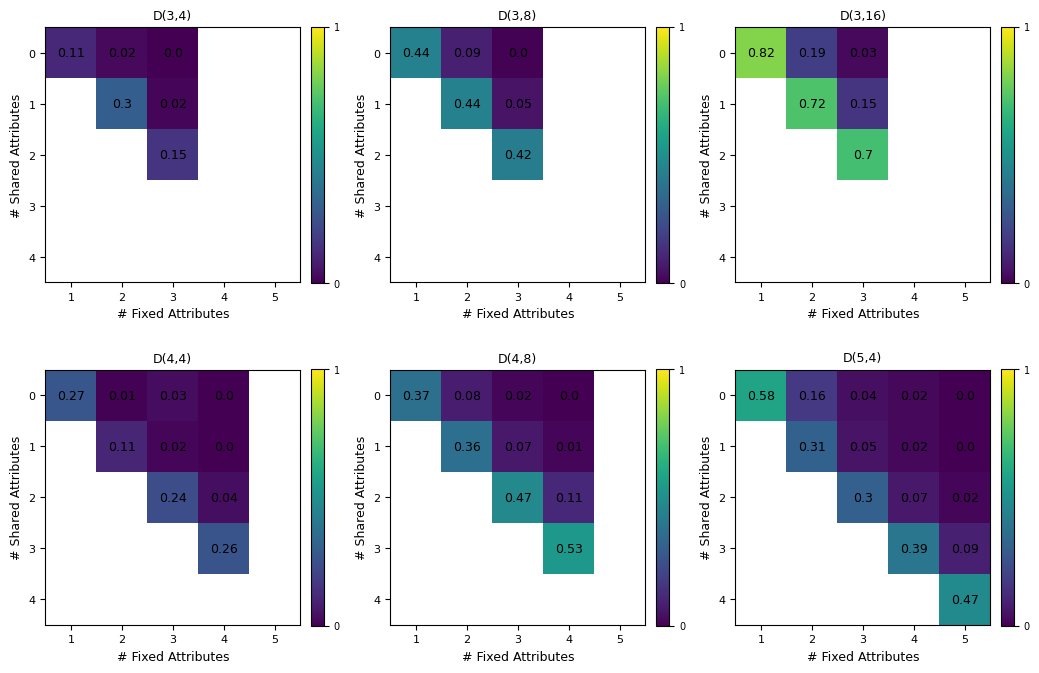

In [104]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

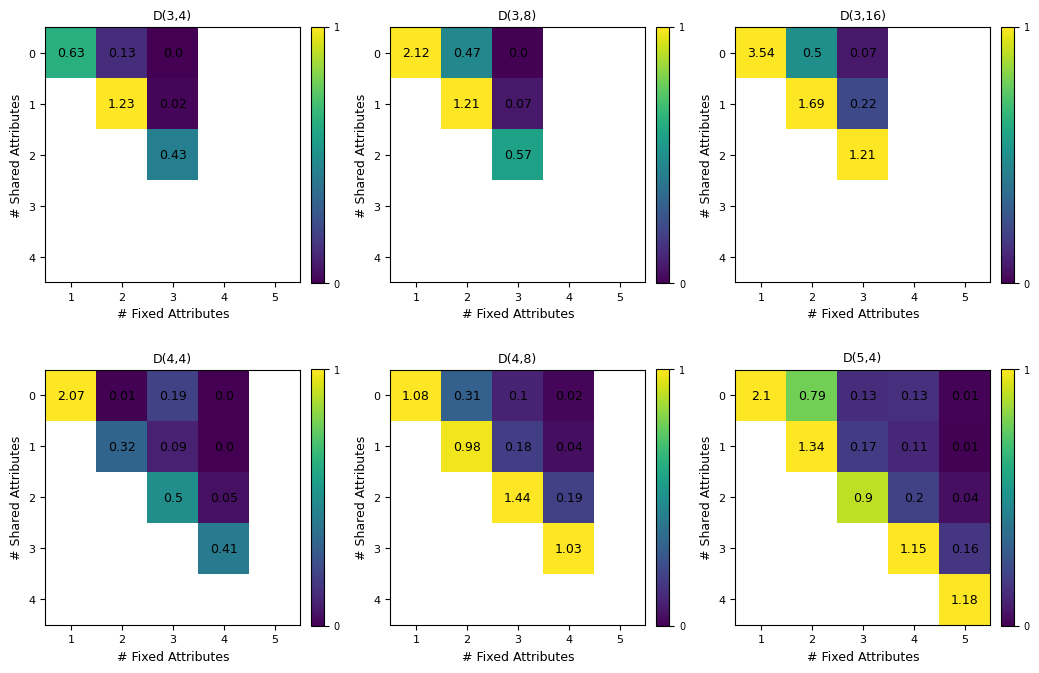

In [204]:
plot_heatmap_concept_x_context_errors(false_objects_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

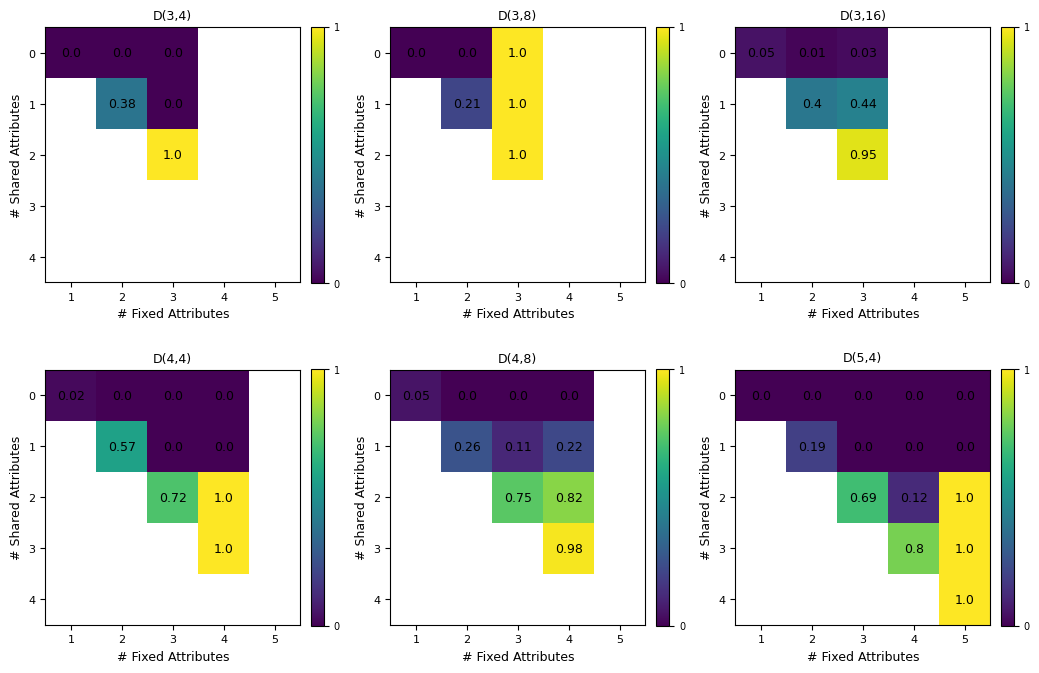

In [196]:
plot_heatmap_concept_x_context_errors(false_positives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

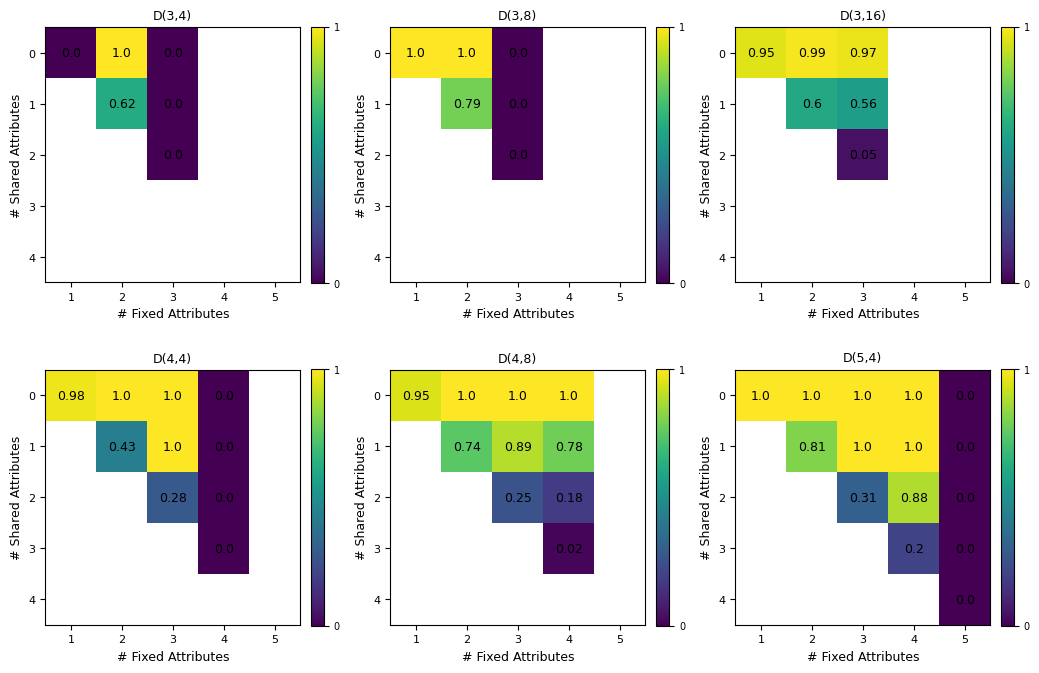

In [197]:
plot_heatmap_concept_x_context_errors(false_negatives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

In [210]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
# objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)] # 1.79
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0)] # 2.58
objects = [(2, 1, 0,), (2, 0, 1), (2, 2, 2), (1, 1, 1), (0, 1, 0), (1, 0, 0)] # 2.58

# 1. Bestimme die Häufigkeit jedes einzigartigen Objekts in der Liste
object_counts = Counter(objects)

# 2. Berechne die relative Häufigkeit jedes Objekts
total_objects = len(objects)
object_probabilities = {obj: count / total_objects for obj, count in object_counts.items()}

# 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
entropy = -sum(prob * np.log2(prob) for prob in object_probabilities.values())

# Ausgabe der berechneten Entropie
print("Die berechnete Entropie beträgt:", entropy)

Die berechnete Entropie beträgt: 2.584962500721156


In [206]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)]

# Transpose the list of objects to get attributes as columns
attributes = np.array(objects).T

# Initialize a list to store the entropy for each attribute
attribute_entropy = []

# Calculate entropy for each attribute
for attribute_values in attributes:
    # 1. Bestimme die Häufigkeit jedes einzigartigen Werts in der Liste
    attribute_counts = Counter(attribute_values)
    
    # 2. Berechne die relative Häufigkeit jedes Werts
    total_values = len(attribute_values)
    value_probabilities = {value: count / total_values for value, count in attribute_counts.items()}
    
    # 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
    entropy = -sum(prob * np.log2(prob) for prob in value_probabilities.values() if prob != 0)
    
    attribute_entropy.append(entropy)

# Ausgabe der berechneten Entropie für jedes Attribut
print("Die berechnete Entropie für jedes Attribut beträgt:", attribute_entropy)

Die berechnete Entropie für jedes Attribut beträgt: [0.6500224216483541, 0.6500224216483541, 0.6500224216483541]


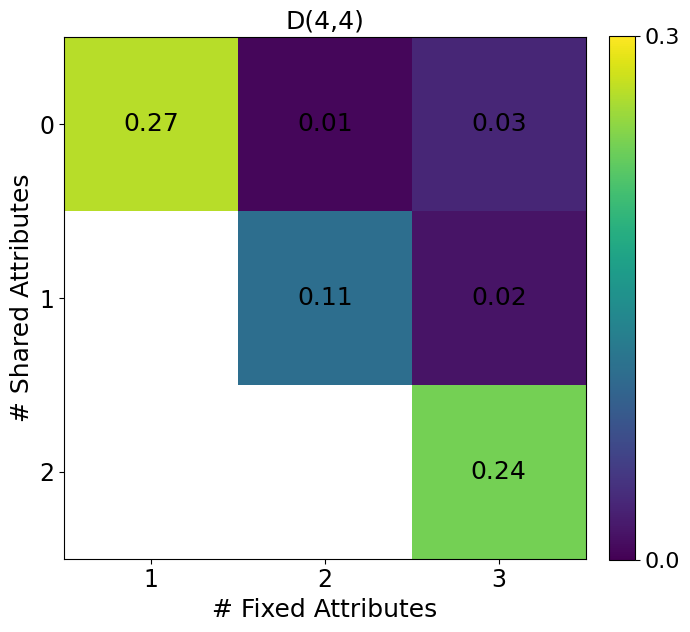

In [211]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context['(4,4)'], one_dataset=True, attributes=4, titles=('D(4,4)',), ylims=(0, 0.3), plot_dims=(1, 1))

# Qualitative analysis

In [44]:
d = 'D(4,4)'
i = 3
save_as = 'lengthcost_unaware'
for run in range(5):
    path_to_run = paths[i] + '/' + str(setting) +'/' + str(run) + '/'
    path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs_all_data[i][run]) + '/interaction_gpu0')
    path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs_all_data[i][run]) + '/interaction_gpu0')
    path_to_interaction_test = (path_to_run + 'interactions/test/epoch_0/interaction_gpu0')
    interaction_train = torch.load(path_to_interaction_train)
    interaction_val = torch.load(path_to_interaction_val)
    interaction_test = torch.load(path_to_interaction_test)
    save_path = paths[i] + '/' + str(setting) +'/qualitative/'

    # retrieve "lexicon" based on mutual information
    # hard-code for D(3,4) for now
    favorite_symbol, mutual_information = symbol_frequency_fav(interaction_train, n_attributes=n_attributes[i], n_values=n_values[i], vocab_size=vocab_sizes[i], is_gumbel=False)
    print(favorite_symbol, mutual_information)
    
    messages = retrieve_messages(interaction_test, is_gumbel=False)
    # remove all symbols after EOS
    messages = [remove_symbs_after_eos(message) for message in messages]

    sender_input = interaction_test.sender_input
    print(sender_input.shape)
    n_targets = int(sender_input.shape[1]/2)
    # get target objects and fixed vectors to re-construct concepts
    target_objects = sender_input[:, :n_targets]
    target_objects = k_hot_to_attributes(target_objects, n_values[i])
    # concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
    (objects, fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
    concepts = list(zip(objects, fixed))

    # get distractor objects to re-construct context conditions
    distractor_objects = sender_input[:, n_targets:]
    distractor_objects = k_hot_to_attributes(distractor_objects, n_values[i])
    context_conds = retrieve_context_condition(objects, fixed, distractor_objects)

    # get random qualitative samples
    #fixed_index = random.randint(0, n_attributes[i]-1) # define a fixed index for the concept
    #n_fixed = random.randint(1, n_attributes[i]) # how many fixed attributes?
    n_fixed = 1
    fixed_indices = random.sample(range(0, n_attributes[i]), k=n_fixed) # select which attributes are fixed
    #fixed_indices = [0, 1, 2, 3]
    fixed_indices = [2]
    #fixed_value = random.randint(0, n_values[i]-1) # define a fixed value for this index
    fixed_values = random.choices(range(0, n_values[i]), k=n_fixed)
    #fixed_values = [2, 0, 3]
    #fixed_values = [1, 2, 1]
    #fixed_values = [2, 2, 3, 3]
    fixed_values = [1, 1, 1, 0]
    print(n_fixed, fixed_indices, fixed_values)
    #index_threshold = 20000 # optional: define some index threshold to make sure that examples are not taken from the beginning of training
    # TODO: adapt this loop such that multiple indices can be fixed
    all_for_this_concept = []
    for idx, (t_objects, t_fixed) in enumerate(concepts):
        #if sum(t_fixed) == 1 and t_fixed[fixed_index] == 1:# and idx > index_threshold:
        if sum(t_fixed) == n_fixed and all(t_fixed[fixed_index] == 1 for fixed_index in fixed_indices):
            for t_object in t_objects:
                if all(t_object[fixed_index] == fixed_values[j] for j, fixed_index in enumerate(fixed_indices)):
                    all_for_this_concept.append((idx, t_object, t_fixed, context_conds[idx], distractor_objects[idx][0], messages[idx], interaction_test.aux['acc'][idx].item()))
                    fixed = t_fixed
    if len(all_for_this_concept) > 0:
        #sample = random.sample(all_for_this_concept, 20)
        sample = all_for_this_concept
        #print(sample)
        column_names = ['game_nr', 'target', 'fixed indices', 'context condition', 'distractor', 'message', 'accuracy']
        df = pd.DataFrame(sample, columns=column_names)
        df = df.groupby('game_nr').first().reset_index()
        print(df)
        if not os.path.exists(save_path + 'test'):
            os.makedirs(save_path + 'test')
        df.to_csv(save_path + 'test/sample' + str(run) + '_' + str(sample[0][1]) + ',' + str(fixed) + '.csv', index=False)
        print('saved ' + save_path + 'test/sample' + str(run) + '_' + str(sample[0][1]) + ',' + str(fixed) + '.csv')
        # find out for which concepts these messages have been used during training
        messages_train = retrieve_messages(interaction_train, is_gumbel=True)
        # remove all symbols after EOS
        messages_train = [remove_symbs_after_eos(message) for message in messages_train]
        sender_input_train = interaction_train.sender_input
        n_targets = int(sender_input_train.shape[1]/2)
        message_usage_train = []
        for j, message in enumerate(messages_train):
            if tuple(message) in get_unique_message_set(df['message']):
                # get target objects and fixed vectors to re-construct concepts
                target_objects = sender_input_train[j, :n_targets].unsqueeze(0)
                target_objects = k_hot_to_attributes(target_objects, n_values[i])
                # concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
                (objects, t_fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
                concepts = list(zip(objects, t_fixed))
            
                # get distractor objects to re-construct context conditions
                distractor_objects = sender_input_train[j, n_targets:].unsqueeze(0)
                distractor_objects = k_hot_to_attributes(distractor_objects, n_values[i])
                context_conds = retrieve_context_condition(objects, t_fixed, distractor_objects)
                message_usage_train.append((j, message, objects[0][0], t_fixed[0], context_conds[0], distractor_objects[0][0], interaction_train.aux['acc'][j].item()))
        if len(message_usage_train) > 0:
            column_names = ['game_nr', 'message', 'targets', 'fixed indices', 'context condition', 'distractors', 'accuracy']
            df_train = pd.DataFrame(message_usage_train, columns=column_names).sort_values('message')
            print(df_train)
            df_train.to_csv(save_path + 'test/mess_usage_train_' + str(run) + '_' + str(sample[0][1]) + ',' + str(fixed) + '.csv', index=False)
            print('saved ' + save_path + 'test/mess_usage_train_' + str(run) + '_' + str(sample[0][1]) + ',' + str(fixed) + '.csv')
        else:
            raise ValueError("Message could not be found in train interactions.")
            
    else:
        raise ValueError("sample for dataset " + str(d) + " could not be generated")

{'00': 1, '01': 1, '02': 1, '03': 2, '10': 3, '11': 3, '12': 3, '13': 3, '20': 3, '21': 4, '22': 3, '23': 3, '30': 3, '31': 3, '32': 3, '33': 2} {'00': 0.004523175526314112, '01': 0.005027758541359105, '02': 0.003649856178036985, '03': 0.00074171106534181, '10': 0.0016847896625052066, '11': 0.0009127646668359552, '12': 0.002789848762760619, '13': 0.004254283242374184, '20': 0.004275411643615254, '21': 0.0011988483807949515, '22': 0.0032252227018774596, '23': 0.00570058626190106, '30': 0.002057921306364494, '31': 0.001405735472750226, '32': 0.0007703418504197447, '33': 0.0016709751246038638}
torch.Size([1250, 20, 16])
1 [2] [1, 1, 1, 0]
   game_nr                target         fixed indices  context condition  \
0       20  [1.0, 1.0, 1.0, 0.0]  [0.0, 0.0, 1.0, 0.0]                  0   
1       21  [3.0, 3.0, 1.0, 2.0]  [0.0, 0.0, 1.0, 0.0]                  0   
2       22  [0.0, 0.0, 1.0, 0.0]  [0.0, 0.0, 1.0, 0.0]                  0   
3       23  [0.0, 3.0, 1.0, 1.0]  [0.0, 0.0, 1.0